# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1081,f15758729f,Renault Kaptur,standart,petrol,3.26,2015,76080,2017,37.40,break_bug
2043,Q-2229156F,Smart ForTwo,economy,petrol,6.44,2013,41238,2019,55.39,engine_check
1515,A-1721538a,Skoda Rapid,economy,petrol,5.04,2017,125139,2018,37.15,break_bug
1855,C19987871T,Kia Rio X,economy,petrol,4.40,2013,45516,2014,28.87,gear_stick
513,l57128172Q,Hyundai Solaris,economy,petrol,4.28,2013,39001,2019,24.38,gear_stick


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
324235,S11442348n,X-1427883w,Q1i,2020-02-09,4.50,23,248,64,103.370445,0,1475.353180,0,4.446126,2.804
117222,c15075180a,I-4335350O,K1Y,2020-03-04,6.52,49,582,33,48.000000,1,1514.416430,0,-11.516885,-24.498
13424,j18514514F,A48818516t,P1c,2020-01-15,6.86,14,176,51,82.000000,0,601.257351,0,-0.282004,-1.215
215054,B13425683U,P-2109405G,B1m,2020-03-28,5.63,65,515,36,73.007756,1,993.719716,0,17.399794,4.894
605876,m74141088p,r-1060256J,C1Y,2020-01-05,5.70,15,161,42,57.000000,0,583.100448,0,-6.612612,0.001


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
1448,39,8.7,1119,14.0,p16070296i,0,2019-1-23
8036,31,8.4,1103,25.0,a22410048T,1,2020-12-1
5711,24,7.4,1073,3.0,K30539321C,1,2020-11-21
9162,41,8.8,870,13.0,K21729961e,0,2020-9-27
8770,31,8.1,1817,8.0,A13922014u,0,2018-4-25


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
125622,x16070571D,PM,2020-11-24 10:15,reparking,1.0,29
62498,Q16225830I,YO,2020-3-12 22:4,reparking,1.0,24
133260,K-1703648s,LN,2019-4-19 12:37,repair,3.8,3
122407,q-2131513C,DZ,2020-12-17 22:58,repair,10.0,67
68904,h-1396839K,UW,2020-6-5 6:39,refuel_check,1.0,25


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

## **Решение 1 задания**

### Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:

- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.

In [6]:
group_of_rides = rides_info.groupby('car_id', as_index=False).agg(
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    count_rides = ('ride_id', 'count')
)

In [7]:
group_of_rides.head()

,car_id,min_rating,mean_rating,sum_distance,speed_max,count_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


### Добавьте минимум 3 признака на свой выбор.

In [8]:
group_of_rides = rides_info.groupby('car_id', as_index=False).agg(
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    count_rides = ('ride_id', 'count'),

    speed_mean = ('speed_avg', 'mean'),
    user_ride_quality_max = ('user_ride_quality', 'max'),
    ride_cost_mean = ('ride_cost', 'mean'),
)

In [9]:
group_of_rides.head()

,car_id,min_rating,mean_rating,sum_distance,speed_max,count_rides,speed_mean,user_ride_quality_max,ride_cost_mean
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,49.459770,8.556052,15201.436782
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174,49.591954,19.324837,27007.477011
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174,43.448276,10.915018,4599.678161
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174,49.379310,4.188281,27379.522989
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174,44.149425,1.038861,16185.545977


### Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

In [10]:
df = pd.merge(car_train, group_of_rides, on='car_id')

In [11]:
df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,sum_distance,speed_max,count_rides,speed_mean,user_ride_quality_max,ride_cost_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,174,44.660920,11.035871,20106.873563
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,1.803909e+07,187.862734,174,49.862069,32.610351,26813.614943
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,1.588366e+07,102.382857,174,44.005747,11.766087,23987.793103
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,1.651883e+07,172.793237,174,49.344828,3.931040,37839.086207
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,1.398317e+07,203.462289,174,50.603448,3.344463,19888.431034


### Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info). Добавьте минимум 3 любых признака с каждого датасета.

In [12]:
# driver_info.head(1)

In [13]:
# fix_info.head(1)

In [14]:
# df = pd.merge(df, rides_info, on='car_id')
# df = pd.merge(df, driver_info[['user_id', 'age', 'user_rides', 'user_rating']], on='user_id')
# df = pd.merge(df, fix_info[['car_id', 'fix_date', 'work_type', 'work_duration']], on='car_id')

In [15]:
# df.head()

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

## **Решение 2 задания**

<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).

In [16]:
cols_for_delete = [col for col in df.columns if df[col].nunique() == 1
                   or df[col].nunique() == df.shape[0]
                   or col in ['ride_id', 'car_id', 'user_id']]

In [17]:
cols_for_delete

['car_id',
 'sum_distance',
 'count_rides',
 'user_ride_quality_max',
 'ride_cost_mean']

In [18]:
df = df.drop(columns=cols_for_delete)

In [19]:
df.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,speed_max,speed_mean
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,180.855726,44.660920
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,187.862734,49.862069
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,102.382857,44.005747
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,172.793237,49.344828
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,203.462289,50.603448


In [20]:
df.shape

(2337, 13)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          2337 non-null   object 
 1   car_type       2337 non-null   object 
 2   fuel_type      2337 non-null   object 
 3   car_rating     2337 non-null   float64
 4   year_to_start  2337 non-null   int64  
 5   riders         2337 non-null   int64  
 6   year_to_work   2337 non-null   int64  
 7   target_reg     2337 non-null   float64
 8   target_class   2337 non-null   object 
 9   min_rating     2337 non-null   float64
 10  mean_rating    2337 non-null   float64
 11  speed_max      2337 non-null   float64
 12  speed_mean     2337 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 255.6+ KB


### Линейная корреляция

In [22]:
# df.corr()

# **У меня переполняется оперативная память при применении функции `df.corr()` из-за большого количества данных, поэтому я перезапустил первые несколько ячеек без merge. Но само первое задание выполнил.**

In [23]:
# df.shape

In [24]:
# df.corr()

In [25]:
# plt.figure(figsize=(16, 10))
# sns.heatmap(df.corr(), annot=True)
# plt.show();

### Phik

In [26]:
# !pip install phik

In [27]:
# import phik
# from phik import report

In [28]:
# phik_matrix = df.phik_matrix()

In [29]:
# print(phik_matrix)

In [30]:
# plt.figure(figsize=(16, 10))
# sns.heatmap(phik_matrix, annot=True)
# plt.show();

### Permutation importance

In [31]:
# Нужна обученная модель, возьму для обучения решающее дерево
# from sklearn.ensemble import RandomForestClassifier

In [32]:
# df.head()

In [33]:
# df['model'].unique()

In [34]:
# df['fuel_type'].unique()

In [35]:
# !pip install category_encoders

In [36]:
# from sklearn.preprocessing import OneHotEncoder
# import category_encoders as ce

# ohe = OneHotEncoder(sparse=False)
# be = ce.BinaryEncoder()

# categorical_cols = df.select_dtypes(include=['object']).columns

In [37]:
# categorical_cols

In [38]:
# for col in categorical_cols:
#     if df[col].nunique() <= 2:
#       print(col)

In [39]:
# categorical_cols

Для столбцов, где больше 2 уникальных значений применяю BinaryEncoding, а для тех, где меньше или равно, то One-Hot Encoding

In [40]:
# for col in categorical_cols:
#     if df[col].nunique() <= 2:
#         transformed = ohe.fit_transform(df[[col]])
#         transformed_df = pd.DataFrame(transformed, columns=[col+'_'+str(i) for i in range(transformed.shape[1])])
#         df = df.join(transformed_df)
#         df = df.drop(col, axis=1)

# categorical_cols = df.select_dtypes(include=['object']).columns

# for col in categorical_cols:
#     transformed = be.fit_transform(df[[col]])
#     transformed_df = pd.DataFrame(transformed, columns=[col+'_'+str(i) for i in range(transformed.shape[1])])
#     df = df.join(transformed_df)
#     df = df.drop(col, axis=1)

# df.head()

#### К сожалению, у меня очень долго считался permutation_importance, поэтому я удалю несколько столбцов для ускорения и демонстрации того, что я всё же воспользовался permutation_importance

In [41]:
# cols_for_delete = ['fuel_type_1',
#                    'model_0',
#                    'model_1',
#                    'model_2',
#                    'model_3',
#                    'model_4',
#                    'car_type_0',
#                    'car_type_1',
#                    'car_type_2',
#                    'target_class_0',
#                    'target_class_1',
#                    'target_class_2',
#                    'target_class_3'
# ]

In [42]:
# df.drop(columns=cols_for_delete)

In [43]:
# model = RandomForestClassifier().fit(df.drop('riders', axis=1), df['riders'])

In [44]:
# from sklearn.inspection import permutation_importance

In [45]:
# res = permutation_importance(model, df.drop('riders', axis=1), df['riders'], n_repeats=10)

In [46]:
# res_sorted_idx = res.importances_mean.argsort()

In [47]:
# res_sorted_idx_flip = np.flip(res_sorted_idx)

#### Визуализация

In [48]:
# fig, ax = plt.subplots(figsize=(16, 10))
# sns.barplot(x=res.importances_mean[res_sorted_idx_flip], y=np.array(df.drop('riders', axis=1).columns)[res_sorted_idx_flip], orient='h', ax=ax)
# ax.set_title('Permutation Importance')
# plt.show();

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

### **Уважаемый Иван, здравствуйте.**

#### У меня проблемы с большим объемом данных, поэтому я снова, как и в первом ДЗ буду работать с ограниченным датасетом без merge большого количества столбцов.

In [49]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.9 MB/s eta 0:00:00


In [50]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [52]:
df.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,speed_max,speed_mean
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,180.855726,44.660920
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,187.862734,49.862069
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,102.382857,44.005747
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,172.793237,49.344828
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,203.462289,50.603448


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          2337 non-null   object 
 1   car_type       2337 non-null   object 
 2   fuel_type      2337 non-null   object 
 3   car_rating     2337 non-null   float64
 4   year_to_start  2337 non-null   int64  
 5   riders         2337 non-null   int64  
 6   year_to_work   2337 non-null   int64  
 7   target_reg     2337 non-null   float64
 8   target_class   2337 non-null   object 
 9   min_rating     2337 non-null   float64
 10  mean_rating    2337 non-null   float64
 11  speed_max      2337 non-null   float64
 12  speed_mean     2337 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 255.6+ KB


In [54]:
categorical_cols = list(df.select_dtypes(include=['object']).columns)
categorical_cols.remove('target_class')
categorical_cols

['model', 'car_type', 'fuel_type']

In [55]:
numerical_cols = list(df.select_dtypes(exclude=['object']).columns)
numerical_cols

['car_rating',
 'year_to_start',
 'riders',
 'year_to_work',
 'target_reg',
 'min_rating',
 'mean_rating',
 'speed_max',
 'speed_mean']

In [56]:
features2drop = [...] # то, что надо выбросить
targets = ['target_class'] # таргеты
cat_features = categorical_cols # категориальные признаки

num_features = numerical_cols # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['model', 'car_type', 'fuel_type']
Числовые признаки: 9 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'speed_max', 'speed_mean']
Целевые переменные ['target_class']


#### Ссылка для рассмотрения функционала `CatBoostClassifier`

[https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [57]:
X = df[num_features]
y = df[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

model = CatBoostClassifier(iterations=3000, verbose=100, early_stopping_rounds=100)
model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.071862
0:	learn: 1.9169541	test: 1.9088581	best: 1.9088581 (0)	total: 67.2ms	remaining: 3m 21s
100:	learn: 0.2762319	test: 0.3197549	best: 0.3197549 (100)	total: 1.6s	remaining: 45.9s
200:	learn: 0.2034405	test: 0.2933275	best: 0.2933275 (200)	total: 2.78s	remaining: 38.7s
300:	learn: 0.1628751	test: 0.2941727	best: 0.2930016 (221)	total: 4.04s	remaining: 36.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2930015707
bestIteration = 221

Shrink model to first 222 iterations.


In [58]:
predictions = model.predict(X_test)
accuracy_score = sklearn.metrics.accuracy_score(y_test, predictions)
round(accuracy_score, 3)

0.9

#### **Вывод:**

Метрика Accuracy порядка 90%, на мой взгляд, это довольно много, но возможно можно и лучше 😀

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

#### **Встроенный метод в CatBoost:**

In [59]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances

,Feature Id,Importances
0,speed_max,21.855770
1,mean_rating,21.572492
2,speed_mean,19.815566
3,target_reg,18.843667
4,min_rating,12.781436
5,car_rating,1.784598
6,riders,1.443606
7,year_to_work,1.296165
8,year_to_start,0.606700


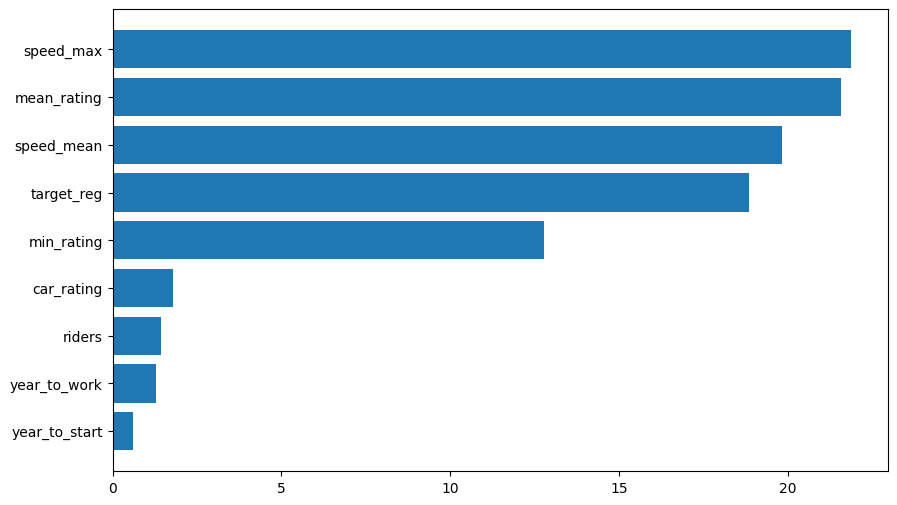

In [60]:
# Получение важности признаков
feature_importances = model.get_feature_importance()
sorted_indices = np.argsort(feature_importances)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices])
plt.yticks(range(len(feature_importances)), X_train.columns[sorted_indices])
plt.show()

#### **Waterfall Plot:**

In [61]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.8 MB/s eta 0:00:00


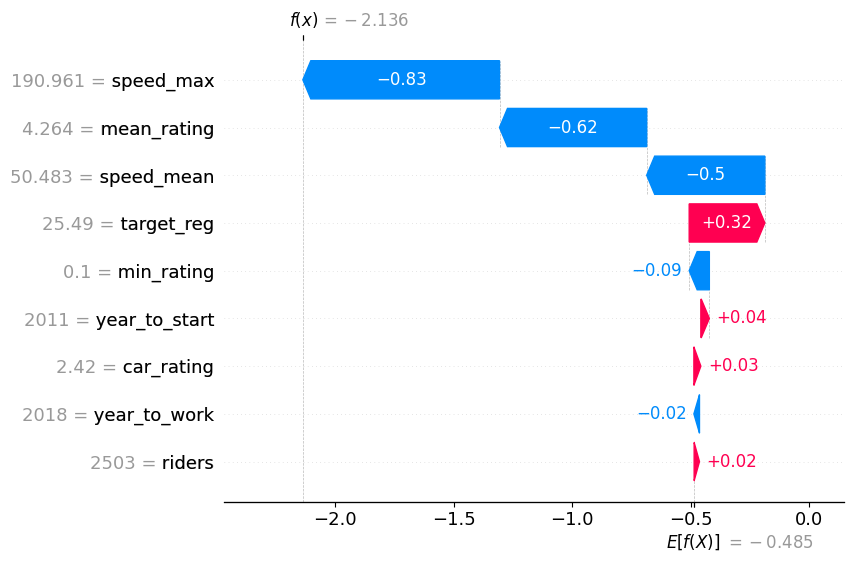

In [62]:
import shap

explainer = shap.Explainer(model=model)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0,:,1])

#### **Classification Report**

In [63]:
from sklearn.metrics import classification_report
report = classification_report(y_test, predictions)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.90      0.97      0.93        58
      break_bug       1.00      1.00      1.00        60
    electro_bug       1.00      1.00      1.00        47
   engine_check       0.90      0.88      0.89        42
    engine_fuel       0.85      0.77      0.81        52
engine_ignition       0.84      0.78      0.81        59
engine_overheat       0.71      0.81      0.76        52
     gear_stick       0.98      0.95      0.97        62
    wheel_shake       0.92      0.94      0.93        36

       accuracy                           0.90       468
      macro avg       0.90      0.90      0.90       468
   weighted avg       0.90      0.90      0.90       468



#### **Confusion Matrix**

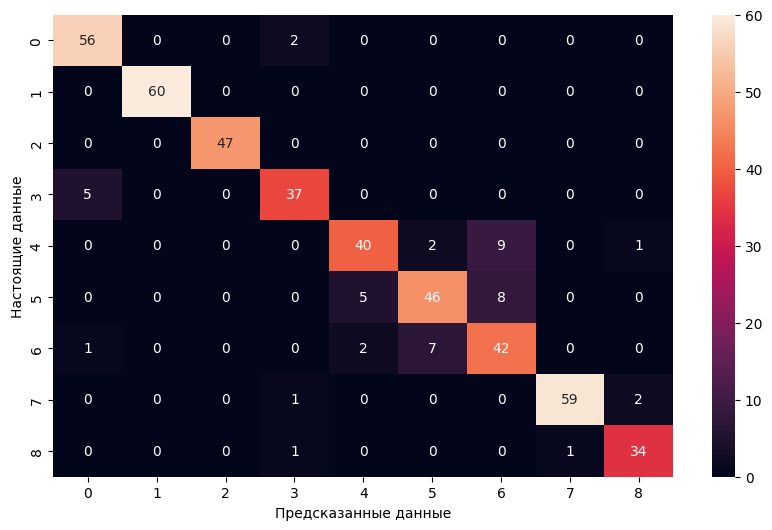

In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True)
plt.xlabel('Предсказанные данные')
plt.ylabel('Настоящие данные')
plt.show();

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          2337 non-null   object 
 1   car_type       2337 non-null   object 
 2   fuel_type      2337 non-null   object 
 3   car_rating     2337 non-null   float64
 4   year_to_start  2337 non-null   int64  
 5   riders         2337 non-null   int64  
 6   year_to_work   2337 non-null   int64  
 7   target_reg     2337 non-null   float64
 8   target_class   2337 non-null   object 
 9   min_rating     2337 non-null   float64
 10  mean_rating    2337 non-null   float64
 11  speed_max      2337 non-null   float64
 12  speed_mean     2337 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 255.6+ KB


In [66]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.4 MB/s eta 0:00:00


In [67]:
import optuna

In [95]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-9, 10),
    }

    model = CatBoostClassifier(**params, random_state=4)
    model.fit(X_train, y_train, verbose=100)

    predictions = model.predict(X_test)

    acc_score_value = sklearn.metrics.accuracy_score(y_test, predictions)

    return acc_score_value

In [96]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-03-30 15:26:06,175] A new study created in memory with name: no-name-ff7214de-bc0d-402d-abec-e61843a7a97c


0:	learn: 1.6972606	total: 94.8ms	remaining: 1m 33s
100:	learn: 0.1418816	total: 8.36s	remaining: 1m 13s
200:	learn: 0.0705214	total: 15.7s	remaining: 1m 1s
300:	learn: 0.0433338	total: 23.9s	remaining: 54.4s
400:	learn: 0.0303166	total: 32.1s	remaining: 46.8s
500:	learn: 0.0228136	total: 39.3s	remaining: 37.9s
600:	learn: 0.0179587	total: 47.6s	remaining: 30.4s
700:	learn: 0.0146840	total: 55.7s	remaining: 22.6s
800:	learn: 0.0123463	total: 1m 3s	remaining: 14.5s
900:	learn: 0.0105385	total: 1m 11s	remaining: 6.65s


[I 2024-03-30 15:27:24,758] Trial 0 finished with value: 0.8931623931623932 and parameters: {'iterations': 985, 'learning_rate': 0.11491821970475234, 'depth': 9, 'l2_leaf_reg': 1.7769893626939404}. Best is trial 0 with value: 0.8931623931623932.


984:	learn: 0.0093630	total: 1m 18s	remaining: 0us
0:	learn: 2.1281274	total: 23.3ms	remaining: 18.4s
100:	learn: 0.6052378	total: 1.3s	remaining: 8.9s
200:	learn: 0.3930879	total: 2.44s	remaining: 7.15s
300:	learn: 0.3279335	total: 3.53s	remaining: 5.74s
400:	learn: 0.2948144	total: 4.61s	remaining: 4.49s
500:	learn: 0.2716570	total: 5.68s	remaining: 3.29s
600:	learn: 0.2541957	total: 6.75s	remaining: 2.13s
700:	learn: 0.2381655	total: 7.82s	remaining: 1s


[I 2024-03-30 15:27:33,640] Trial 1 finished with value: 0.8974358974358975 and parameters: {'iterations': 791, 'learning_rate': 0.01579021069705002, 'depth': 6, 'l2_leaf_reg': 4.101004790890639}. Best is trial 1 with value: 0.8974358974358975.


790:	learn: 0.2267055	total: 8.77s	remaining: 0us
0:	learn: 1.9879558	total: 10.8ms	remaining: 2.89s
100:	learn: 0.2997907	total: 1.12s	remaining: 1.84s
200:	learn: 0.2111567	total: 2.81s	remaining: 936ms


[I 2024-03-30 15:27:37,657] Trial 2 finished with value: 0.9038461538461539 and parameters: {'iterations': 268, 'learning_rate': 0.0407789042397448, 'depth': 6, 'l2_leaf_reg': 0.5670260393498224}. Best is trial 2 with value: 0.9038461538461539.


267:	learn: 0.1761709	total: 3.95s	remaining: 0us
0:	learn: 1.3460278	total: 76.5ms	remaining: 26.8s
100:	learn: 0.1230318	total: 7.53s	remaining: 18.6s
200:	learn: 0.0640274	total: 15.9s	remaining: 11.9s
300:	learn: 0.0410847	total: 24.2s	remaining: 4.02s


[I 2024-03-30 15:28:05,614] Trial 3 finished with value: 0.8931623931623932 and parameters: {'iterations': 351, 'learning_rate': 0.28016311811087397, 'depth': 9, 'l2_leaf_reg': 5.967033224472933}. Best is trial 2 with value: 0.9038461538461539.


350:	learn: 0.0345162	total: 27.9s	remaining: 0us
0:	learn: 1.4975098	total: 37.2ms	remaining: 10.3s
100:	learn: 0.1365293	total: 3.96s	remaining: 6.94s
200:	learn: 0.0715424	total: 8.52s	remaining: 3.26s


[I 2024-03-30 15:28:17,033] Trial 4 finished with value: 0.8931623931623932 and parameters: {'iterations': 278, 'learning_rate': 0.17546576726086754, 'depth': 8, 'l2_leaf_reg': 2.718209732022972}. Best is trial 2 with value: 0.9038461538461539.


277:	learn: 0.0494374	total: 11.3s	remaining: 0us
0:	learn: 1.5474708	total: 19.5ms	remaining: 9.37s
100:	learn: 0.1314451	total: 1.93s	remaining: 7.27s
200:	learn: 0.0674051	total: 3.9s	remaining: 5.45s
300:	learn: 0.0407722	total: 5.92s	remaining: 3.56s
400:	learn: 0.0275819	total: 8.69s	remaining: 1.75s


[I 2024-03-30 15:28:27,539] Trial 5 finished with value: 0.8995726495726496 and parameters: {'iterations': 482, 'learning_rate': 0.1417441219247969, 'depth': 7, 'l2_leaf_reg': 1.0580476114913802}. Best is trial 2 with value: 0.9038461538461539.


481:	learn: 0.0212131	total: 10.4s	remaining: 0us
0:	learn: 1.6063108	total: 3.68ms	remaining: 1.76s
100:	learn: 0.2273895	total: 369ms	remaining: 1.38s
200:	learn: 0.1646139	total: 745ms	remaining: 1.03s
300:	learn: 0.1297585	total: 1.13s	remaining: 664ms
400:	learn: 0.1030473	total: 1.5s	remaining: 288ms


[I 2024-03-30 15:28:29,395] Trial 6 finished with value: 0.8910256410256411 and parameters: {'iterations': 478, 'learning_rate': 0.17706941990126837, 'depth': 4, 'l2_leaf_reg': 2.4799665039406933}. Best is trial 2 with value: 0.9038461538461539.


477:	learn: 0.0876568	total: 1.79s	remaining: 0us
0:	learn: 1.8949866	total: 20ms	remaining: 5.03s
100:	learn: 0.2244152	total: 1.96s	remaining: 2.94s
200:	learn: 0.1337047	total: 3.89s	remaining: 986ms


[I 2024-03-30 15:28:34,338] Trial 7 finished with value: 0.8888888888888888 and parameters: {'iterations': 252, 'learning_rate': 0.059802430999751695, 'depth': 7, 'l2_leaf_reg': 0.4845883771247729}. Best is trial 2 with value: 0.9038461538461539.


251:	learn: 0.1063680	total: 4.88s	remaining: 0us
0:	learn: 1.9450733	total: 8.43ms	remaining: 894ms


[I 2024-03-30 15:28:35,048] Trial 8 finished with value: 0.8931623931623932 and parameters: {'iterations': 107, 'learning_rate': 0.056512987535742104, 'depth': 5, 'l2_leaf_reg': 1.2602206958529099}. Best is trial 2 with value: 0.9038461538461539.


100:	learn: 0.2916474	total: 633ms	remaining: 37.6ms
106:	learn: 0.2860418	total: 669ms	remaining: 0us
0:	learn: 1.2221369	total: 36.4ms	remaining: 15.1s
100:	learn: 0.1135799	total: 4.67s	remaining: 14.6s
200:	learn: 0.0545530	total: 8.24s	remaining: 8.86s
300:	learn: 0.0338857	total: 11.9s	remaining: 4.58s
400:	learn: 0.0239009	total: 16.4s	remaining: 654ms


[I 2024-03-30 15:28:52,137] Trial 9 finished with value: 0.8824786324786325 and parameters: {'iterations': 417, 'learning_rate': 0.2899777373140817, 'depth': 8, 'l2_leaf_reg': 4.186017034845564}. Best is trial 2 with value: 0.9038461538461539.


416:	learn: 0.0228898	total: 17s	remaining: 0us
0:	learn: 1.9837174	total: 2.66ms	remaining: 1.74s
100:	learn: 0.3291412	total: 254ms	remaining: 1.4s
200:	learn: 0.2808946	total: 502ms	remaining: 1.13s
300:	learn: 0.2546349	total: 757ms	remaining: 890ms
400:	learn: 0.2371829	total: 1.03s	remaining: 651ms
500:	learn: 0.2224740	total: 1.28s	remaining: 392ms


[I 2024-03-30 15:28:53,899] Trial 10 finished with value: 0.9038461538461539 and parameters: {'iterations': 655, 'learning_rate': 0.0943099396330058, 'depth': 3, 'l2_leaf_reg': 9.348291056165994}. Best is trial 2 with value: 0.9038461538461539.


600:	learn: 0.2112856	total: 1.54s	remaining: 138ms
654:	learn: 0.2068117	total: 1.67s	remaining: 0us
0:	learn: 2.0282572	total: 2.58ms	remaining: 1.7s
100:	learn: 0.3567882	total: 276ms	remaining: 1.53s
200:	learn: 0.3007139	total: 529ms	remaining: 1.21s
300:	learn: 0.2714974	total: 780ms	remaining: 928ms
400:	learn: 0.2553204	total: 1.02s	remaining: 657ms
500:	learn: 0.2409154	total: 1.28s	remaining: 404ms


[I 2024-03-30 15:28:55,704] Trial 11 finished with value: 0.9038461538461539 and parameters: {'iterations': 659, 'learning_rate': 0.07457354132330521, 'depth': 3, 'l2_leaf_reg': 9.766723742909237}. Best is trial 2 with value: 0.9038461538461539.


600:	learn: 0.2299098	total: 1.55s	remaining: 150ms
658:	learn: 0.2249847	total: 1.71s	remaining: 0us
0:	learn: 2.1705349	total: 2.43ms	remaining: 1.62s
100:	learn: 1.0334700	total: 257ms	remaining: 1.45s
200:	learn: 0.6870944	total: 525ms	remaining: 1.22s
300:	learn: 0.5288790	total: 779ms	remaining: 953ms
400:	learn: 0.4459311	total: 1.03s	remaining: 690ms
500:	learn: 0.3984325	total: 1.29s	remaining: 433ms
600:	learn: 0.3702802	total: 1.58s	remaining: 179ms
668:	learn: 0.3552317	total: 1.76s	remaining: 0us


[I 2024-03-30 15:28:57,559] Trial 12 finished with value: 0.8910256410256411 and parameters: {'iterations': 669, 'learning_rate': 0.010973634252123655, 'depth': 3, 'l2_leaf_reg': 7.786828575646548}. Best is trial 2 with value: 0.9038461538461539.


0:	learn: 1.7902484	total: 6.94ms	remaining: 4.57s
100:	learn: 0.2666284	total: 650ms	remaining: 3.59s
200:	learn: 0.2119306	total: 1.23s	remaining: 2.81s
300:	learn: 0.1803326	total: 1.85s	remaining: 2.2s
400:	learn: 0.1567771	total: 2.49s	remaining: 1.6s
500:	learn: 0.1379408	total: 3.44s	remaining: 1.08s
600:	learn: 0.1229542	total: 4.47s	remaining: 432ms


[I 2024-03-30 15:29:02,752] Trial 13 finished with value: 0.8931623931623932 and parameters: {'iterations': 659, 'learning_rate': 0.11670039826697765, 'depth': 5, 'l2_leaf_reg': 6.673467628203713}. Best is trial 2 with value: 0.9038461538461539.


658:	learn: 0.1155820	total: 5.09s	remaining: 0us
0:	learn: 1.9089009	total: 6.14ms	remaining: 5.04s
100:	learn: 0.2970466	total: 630ms	remaining: 4.5s
200:	learn: 0.2496801	total: 1.21s	remaining: 3.75s
300:	learn: 0.2216161	total: 1.83s	remaining: 3.17s
400:	learn: 0.1994393	total: 2.46s	remaining: 2.59s
500:	learn: 0.1814508	total: 3.08s	remaining: 1.97s
600:	learn: 0.1676379	total: 3.7s	remaining: 1.36s
700:	learn: 0.1539942	total: 4.31s	remaining: 744ms


[I 2024-03-30 15:29:07,964] Trial 14 finished with value: 0.8952991452991453 and parameters: {'iterations': 822, 'learning_rate': 0.09006264145203875, 'depth': 5, 'l2_leaf_reg': 9.829099688237168}. Best is trial 2 with value: 0.9038461538461539.


800:	learn: 0.1425154	total: 4.97s	remaining: 130ms
821:	learn: 0.1406426	total: 5.11s	remaining: 0us
0:	learn: 1.5176695	total: 156ms	remaining: 18.1s
100:	learn: 0.1532442	total: 15.9s	remaining: 2.51s


[I 2024-03-30 15:29:27,065] Trial 15 finished with value: 0.8995726495726496 and parameters: {'iterations': 117, 'learning_rate': 0.23362444425332837, 'depth': 10, 'l2_leaf_reg': 7.682041762774681}. Best is trial 2 with value: 0.9038461538461539.


116:	learn: 0.1368791	total: 19s	remaining: 0us
0:	learn: 2.0823170	total: 6.3ms	remaining: 3.77s
100:	learn: 0.4246891	total: 483ms	remaining: 2.39s
200:	learn: 0.3274039	total: 897ms	remaining: 1.78s
300:	learn: 0.2924766	total: 1.29s	remaining: 1.28s
400:	learn: 0.2712530	total: 1.66s	remaining: 826ms
500:	learn: 0.2570352	total: 2.03s	remaining: 401ms


[I 2024-03-30 15:29:29,583] Trial 16 finished with value: 0.8974358974358975 and parameters: {'iterations': 600, 'learning_rate': 0.03767790241836206, 'depth': 4, 'l2_leaf_reg': 8.250989684692831}. Best is trial 2 with value: 0.9038461538461539.


599:	learn: 0.2437225	total: 2.41s	remaining: 0us
0:	learn: 1.7365033	total: 11.3ms	remaining: 9.01s
100:	learn: 0.2422072	total: 1.12s	remaining: 7.67s
200:	learn: 0.1789146	total: 2.19s	remaining: 6.48s
300:	learn: 0.1419045	total: 3.27s	remaining: 5.37s
400:	learn: 0.1170821	total: 4.37s	remaining: 4.29s
500:	learn: 0.0977353	total: 5.46s	remaining: 3.21s
600:	learn: 0.0828657	total: 6.55s	remaining: 2.12s
700:	learn: 0.0714787	total: 7.64s	remaining: 1.02s


[I 2024-03-30 15:29:39,161] Trial 17 finished with value: 0.8952991452991453 and parameters: {'iterations': 795, 'learning_rate': 0.1153660359713194, 'depth': 6, 'l2_leaf_reg': 5.133587133533961}. Best is trial 2 with value: 0.9038461538461539.


794:	learn: 0.0630021	total: 9.44s	remaining: 0us
0:	learn: 1.4635240	total: 5.31ms	remaining: 1.17s
100:	learn: 0.1545035	total: 550ms	remaining: 654ms


[I 2024-03-30 15:29:40,252] Trial 18 finished with value: 0.8952991452991453 and parameters: {'iterations': 221, 'learning_rate': 0.20826053083067345, 'depth': 4, 'l2_leaf_reg': 0.09307337514301128}. Best is trial 2 with value: 0.9038461538461539.


200:	learn: 0.0795303	total: 930ms	remaining: 92.6ms
220:	learn: 0.0708952	total: 1.01s	remaining: 0us
0:	learn: 1.9645854	total: 2.7ms	remaining: 1.41s
100:	learn: 0.3132674	total: 267ms	remaining: 1.12s
200:	learn: 0.2601652	total: 506ms	remaining: 815ms
300:	learn: 0.2309312	total: 749ms	remaining: 557ms
400:	learn: 0.2085114	total: 989ms	remaining: 306ms


[I 2024-03-30 15:29:41,632] Trial 19 finished with value: 0.9017094017094017 and parameters: {'iterations': 525, 'learning_rate': 0.08938360112255253, 'depth': 3, 'l2_leaf_reg': 3.3028175961409496}. Best is trial 2 with value: 0.9038461538461539.


500:	learn: 0.1920086	total: 1.23s	remaining: 59ms
524:	learn: 0.1890552	total: 1.3s	remaining: 0us
0:	learn: 2.0485189	total: 11ms	remaining: 4.06s
100:	learn: 0.3782241	total: 1.06s	remaining: 2.82s
200:	learn: 0.2915989	total: 2.14s	remaining: 1.8s
300:	learn: 0.2553564	total: 3.21s	remaining: 737ms


[I 2024-03-30 15:29:45,652] Trial 20 finished with value: 0.8995726495726496 and parameters: {'iterations': 370, 'learning_rate': 0.03701980173596968, 'depth': 6, 'l2_leaf_reg': 6.030052370804828}. Best is trial 2 with value: 0.9038461538461539.


369:	learn: 0.2372432	total: 3.93s	remaining: 0us
0:	learn: 2.0158032	total: 2.47ms	remaining: 1.67s
100:	learn: 0.3480494	total: 248ms	remaining: 1.41s
200:	learn: 0.2958488	total: 496ms	remaining: 1.17s
300:	learn: 0.2677928	total: 746ms	remaining: 929ms
400:	learn: 0.2506927	total: 1s	remaining: 689ms
500:	learn: 0.2363517	total: 1.24s	remaining: 433ms
600:	learn: 0.2253120	total: 1.48s	remaining: 185ms
675:	learn: 0.2186955	total: 1.67s	remaining: 0us


[I 2024-03-30 15:29:47,416] Trial 21 finished with value: 0.9038461538461539 and parameters: {'iterations': 676, 'learning_rate': 0.08055737596552422, 'depth': 3, 'l2_leaf_reg': 9.926569553223242}. Best is trial 2 with value: 0.9038461538461539.


0:	learn: 1.9923608	total: 4.15ms	remaining: 2.36s
100:	learn: 0.3357385	total: 398ms	remaining: 1.85s
200:	learn: 0.2771114	total: 766ms	remaining: 1.41s
300:	learn: 0.2507087	total: 1.12s	remaining: 1s
400:	learn: 0.2318703	total: 1.51s	remaining: 637ms
500:	learn: 0.2174187	total: 1.88s	remaining: 259ms


[I 2024-03-30 15:29:49,708] Trial 22 finished with value: 0.905982905982906 and parameters: {'iterations': 570, 'learning_rate': 0.0697819409120387, 'depth': 4, 'l2_leaf_reg': 9.146937790569396}. Best is trial 22 with value: 0.905982905982906.


569:	learn: 0.2080005	total: 2.2s	remaining: 0us
0:	learn: 2.0801315	total: 7.98ms	remaining: 4.71s
100:	learn: 0.4193315	total: 706ms	remaining: 3.43s
200:	learn: 0.3244773	total: 1.49s	remaining: 2.9s
300:	learn: 0.2913010	total: 2.1s	remaining: 2.03s
400:	learn: 0.2707204	total: 2.48s	remaining: 1.18s
500:	learn: 0.2568996	total: 2.86s	remaining: 519ms


[I 2024-03-30 15:29:53,046] Trial 23 finished with value: 0.8952991452991453 and parameters: {'iterations': 592, 'learning_rate': 0.03910426903446408, 'depth': 4, 'l2_leaf_reg': 8.903049627939488}. Best is trial 22 with value: 0.905982905982906.


591:	learn: 0.2450266	total: 3.21s	remaining: 0us
0:	learn: 1.7787935	total: 6.29ms	remaining: 5.6s
100:	learn: 0.2664619	total: 629ms	remaining: 4.91s
200:	learn: 0.2165666	total: 1.26s	remaining: 4.32s
300:	learn: 0.1850677	total: 1.87s	remaining: 3.67s
400:	learn: 0.1627791	total: 2.5s	remaining: 3.05s
500:	learn: 0.1447844	total: 3.15s	remaining: 2.44s
600:	learn: 0.1302219	total: 3.74s	remaining: 1.8s
700:	learn: 0.1169411	total: 4.35s	remaining: 1.17s
800:	learn: 0.1062286	total: 4.97s	remaining: 552ms


[I 2024-03-30 15:29:58,687] Trial 24 finished with value: 0.8974358974358975 and parameters: {'iterations': 890, 'learning_rate': 0.12898799139969339, 'depth': 5, 'l2_leaf_reg': 8.765498536570407}. Best is trial 22 with value: 0.905982905982906.


889:	learn: 0.0974004	total: 5.52s	remaining: 0us
0:	learn: 1.8940571	total: 3.88ms	remaining: 2.89s
100:	learn: 0.2983671	total: 378ms	remaining: 2.42s
200:	learn: 0.2442461	total: 749ms	remaining: 2.03s
300:	learn: 0.2159598	total: 1.11s	remaining: 1.65s
400:	learn: 0.1951235	total: 1.49s	remaining: 1.28s
500:	learn: 0.1795900	total: 1.89s	remaining: 930ms
600:	learn: 0.1649144	total: 2.26s	remaining: 549ms


[I 2024-03-30 15:30:01,596] Trial 25 finished with value: 0.8974358974358975 and parameters: {'iterations': 747, 'learning_rate': 0.09859616905277246, 'depth': 4, 'l2_leaf_reg': 6.924066438088866}. Best is trial 22 with value: 0.905982905982906.


700:	learn: 0.1510766	total: 2.65s	remaining: 174ms
746:	learn: 0.1458919	total: 2.81s	remaining: 0us
0:	learn: 2.0449666	total: 2.47ms	remaining: 1.11s
100:	learn: 0.3681125	total: 362ms	remaining: 1.25s
200:	learn: 0.3060266	total: 809ms	remaining: 1s
300:	learn: 0.2755903	total: 1.29s	remaining: 639ms
400:	learn: 0.2591412	total: 1.79s	remaining: 219ms
449:	learn: 0.2514687	total: 1.98s	remaining: 0us


[I 2024-03-30 15:30:03,670] Trial 26 finished with value: 0.8931623931623932 and parameters: {'iterations': 450, 'learning_rate': 0.06562837518225585, 'depth': 3, 'l2_leaf_reg': 8.83387673781472}. Best is trial 22 with value: 0.905982905982906.


0:	learn: 1.6680423	total: 15.8ms	remaining: 8.83s
100:	learn: 0.2468489	total: 709ms	remaining: 3.23s
200:	learn: 0.1928384	total: 1.31s	remaining: 2.35s
300:	learn: 0.1599766	total: 1.94s	remaining: 1.67s
400:	learn: 0.1353761	total: 2.55s	remaining: 1.02s
500:	learn: 0.1163111	total: 3.16s	remaining: 379ms


[I 2024-03-30 15:30:07,338] Trial 27 finished with value: 0.8910256410256411 and parameters: {'iterations': 561, 'learning_rate': 0.15804403791557153, 'depth': 5, 'l2_leaf_reg': 7.209172283121744}. Best is trial 22 with value: 0.905982905982906.


560:	learn: 0.1070051	total: 3.55s	remaining: 0us
0:	learn: 2.0446683	total: 19.7ms	remaining: 10.2s
100:	learn: 0.3633968	total: 2.06s	remaining: 8.51s
200:	learn: 0.2734804	total: 3.96s	remaining: 6.27s
300:	learn: 0.2301166	total: 5.81s	remaining: 4.21s
400:	learn: 0.2011864	total: 8.55s	remaining: 2.52s
500:	learn: 0.1789419	total: 10.5s	remaining: 377ms


[I 2024-03-30 15:30:18,283] Trial 28 finished with value: 0.8910256410256411 and parameters: {'iterations': 519, 'learning_rate': 0.03838511536086886, 'depth': 7, 'l2_leaf_reg': 5.061524056311525}. Best is trial 22 with value: 0.905982905982906.


518:	learn: 0.1754656	total: 10.8s	remaining: 0us
0:	learn: 1.8639001	total: 3.82ms	remaining: 3.47s
100:	learn: 0.2894600	total: 378ms	remaining: 3.03s
200:	learn: 0.2338152	total: 766ms	remaining: 2.7s
300:	learn: 0.2048342	total: 1.15s	remaining: 2.33s
400:	learn: 0.1830490	total: 1.53s	remaining: 1.94s
500:	learn: 0.1664305	total: 1.91s	remaining: 1.56s
600:	learn: 0.1521608	total: 2.31s	remaining: 1.18s
700:	learn: 0.1376925	total: 2.68s	remaining: 795ms
800:	learn: 0.1273981	total: 3.07s	remaining: 414ms


[I 2024-03-30 15:30:21,886] Trial 29 finished with value: 0.8952991452991453 and parameters: {'iterations': 909, 'learning_rate': 0.10628420510975749, 'depth': 4, 'l2_leaf_reg': 6.083738581888011}. Best is trial 22 with value: 0.905982905982906.


900:	learn: 0.1173345	total: 3.46s	remaining: 30.7ms
908:	learn: 0.1163708	total: 3.49s	remaining: 0us
0:	learn: 2.0936796	total: 10.9ms	remaining: 7.87s
100:	learn: 0.4564002	total: 1.1s	remaining: 6.77s
200:	learn: 0.3166662	total: 2.22s	remaining: 5.77s
300:	learn: 0.2695915	total: 3.3s	remaining: 4.63s
400:	learn: 0.2384002	total: 4.61s	remaining: 3.7s
500:	learn: 0.2148219	total: 6.35s	remaining: 2.81s
600:	learn: 0.1963163	total: 7.43s	remaining: 1.51s
700:	learn: 0.1809037	total: 8.49s	remaining: 266ms


[I 2024-03-30 15:30:30,737] Trial 30 finished with value: 0.8974358974358975 and parameters: {'iterations': 723, 'learning_rate': 0.02171324241052333, 'depth': 6, 'l2_leaf_reg': 2.1304423370989705}. Best is trial 22 with value: 0.905982905982906.


722:	learn: 0.1776150	total: 8.72s	remaining: 0us
0:	learn: 2.0304975	total: 2.66ms	remaining: 1.64s
100:	learn: 0.3574347	total: 290ms	remaining: 1.49s
200:	learn: 0.3000682	total: 545ms	remaining: 1.13s
300:	learn: 0.2705543	total: 817ms	remaining: 863ms
400:	learn: 0.2544019	total: 1.09s	remaining: 595ms
500:	learn: 0.2397749	total: 1.35s	remaining: 318ms


[I 2024-03-30 15:30:32,474] Trial 31 finished with value: 0.8995726495726496 and parameters: {'iterations': 619, 'learning_rate': 0.0727184410515482, 'depth': 3, 'l2_leaf_reg': 9.23683449449848}. Best is trial 22 with value: 0.905982905982906.


600:	learn: 0.2290177	total: 1.6s	remaining: 47.9ms
618:	learn: 0.2271324	total: 1.65s	remaining: 0us
0:	learn: 2.0777133	total: 2.61ms	remaining: 1.88s
100:	learn: 0.4099930	total: 248ms	remaining: 1.53s
200:	learn: 0.3239341	total: 504ms	remaining: 1.31s
300:	learn: 0.2922618	total: 752ms	remaining: 1.06s
400:	learn: 0.2742365	total: 994ms	remaining: 801ms
500:	learn: 0.2600258	total: 1.23s	remaining: 548ms
600:	learn: 0.2500262	total: 1.48s	remaining: 303ms


[I 2024-03-30 15:30:34,353] Trial 32 finished with value: 0.8952991452991453 and parameters: {'iterations': 724, 'learning_rate': 0.05188278970118322, 'depth': 3, 'l2_leaf_reg': 9.469791368351908}. Best is trial 22 with value: 0.905982905982906.


700:	learn: 0.2403725	total: 1.72s	remaining: 56.6ms
723:	learn: 0.2385257	total: 1.78s	remaining: 0us
0:	learn: 2.0164894	total: 2.71ms	remaining: 870ms
100:	learn: 0.3480076	total: 246ms	remaining: 539ms
200:	learn: 0.2935841	total: 490ms	remaining: 295ms


[I 2024-03-30 15:30:35,229] Trial 33 finished with value: 0.8931623931623932 and parameters: {'iterations': 322, 'learning_rate': 0.07708286321271686, 'depth': 3, 'l2_leaf_reg': 8.083300176936568}. Best is trial 22 with value: 0.905982905982906.


300:	learn: 0.2655554	total: 748ms	remaining: 52.2ms
321:	learn: 0.2610112	total: 802ms	remaining: 0us
0:	learn: 1.8349680	total: 3.99ms	remaining: 695ms
100:	learn: 0.2855892	total: 374ms	remaining: 274ms


[I 2024-03-30 15:30:35,946] Trial 34 finished with value: 0.8952991452991453 and parameters: {'iterations': 175, 'learning_rate': 0.12391754086896162, 'depth': 4, 'l2_leaf_reg': 8.300863912488222}. Best is trial 22 with value: 0.905982905982906.


174:	learn: 0.2466497	total: 650ms	remaining: 0us
0:	learn: 2.0872058	total: 45.3ms	remaining: 24.6s
100:	learn: 0.4257473	total: 4.62s	remaining: 20.3s
200:	learn: 0.3009150	total: 8.16s	remaining: 14s
300:	learn: 0.2481900	total: 11.8s	remaining: 9.53s
400:	learn: 0.2125907	total: 16s	remaining: 5.75s
500:	learn: 0.1872417	total: 19.9s	remaining: 1.75s


[I 2024-03-30 15:30:57,577] Trial 35 finished with value: 0.8952991452991453 and parameters: {'iterations': 545, 'learning_rate': 0.027928936004317888, 'depth': 8, 'l2_leaf_reg': 4.308568895603114}. Best is trial 22 with value: 0.905982905982906.


544:	learn: 0.1780303	total: 21.5s	remaining: 0us
0:	learn: 1.6344439	total: 74.9ms	remaining: 31.4s
100:	learn: 0.1537464	total: 8.04s	remaining: 25.4s
200:	learn: 0.0838537	total: 15.4s	remaining: 16.8s
300:	learn: 0.0543558	total: 23.4s	remaining: 9.26s
400:	learn: 0.0394427	total: 31.5s	remaining: 1.49s


[I 2024-03-30 15:31:30,690] Trial 36 finished with value: 0.8846153846153846 and parameters: {'iterations': 420, 'learning_rate': 0.14918518949664014, 'depth': 9, 'l2_leaf_reg': 3.5131795927929717}. Best is trial 22 with value: 0.905982905982906.


419:	learn: 0.0373552	total: 33s	remaining: 0us
0:	learn: 2.0661116	total: 2.69ms	remaining: 1.69s
100:	learn: 0.3927679	total: 252ms	remaining: 1.32s
200:	learn: 0.3175812	total: 500ms	remaining: 1.07s
300:	learn: 0.2858828	total: 768ms	remaining: 842ms
400:	learn: 0.2689983	total: 1.02s	remaining: 587ms
500:	learn: 0.2546488	total: 1.26s	remaining: 327ms


[I 2024-03-30 15:31:32,361] Trial 37 finished with value: 0.8910256410256411 and parameters: {'iterations': 631, 'learning_rate': 0.056895547539794124, 'depth': 3, 'l2_leaf_reg': 9.34257538966666}. Best is trial 22 with value: 0.905982905982906.


600:	learn: 0.2444403	total: 1.51s	remaining: 75.2ms
630:	learn: 0.2412510	total: 1.58s	remaining: 0us
0:	learn: 1.8991829	total: 5.98ms	remaining: 5.11s
100:	learn: 0.2955849	total: 606ms	remaining: 4.52s
200:	learn: 0.2492206	total: 1.18s	remaining: 3.82s
300:	learn: 0.2199477	total: 1.77s	remaining: 3.26s
400:	learn: 0.1974500	total: 2.38s	remaining: 2.7s
500:	learn: 0.1799402	total: 2.98s	remaining: 2.11s
600:	learn: 0.1656138	total: 3.59s	remaining: 1.52s
700:	learn: 0.1521652	total: 4.19s	remaining: 921ms
800:	learn: 0.1403241	total: 4.81s	remaining: 324ms


[I 2024-03-30 15:31:37,614] Trial 38 finished with value: 0.8974358974358975 and parameters: {'iterations': 855, 'learning_rate': 0.09361895867199457, 'depth': 5, 'l2_leaf_reg': 9.964344453626568}. Best is trial 22 with value: 0.905982905982906.


854:	learn: 0.1341839	total: 5.14s	remaining: 0us
0:	learn: 2.0093902	total: 4.03ms	remaining: 2.84s
100:	learn: 0.3335992	total: 408ms	remaining: 2.44s
200:	learn: 0.2614126	total: 786ms	remaining: 1.97s
300:	learn: 0.2240175	total: 1.27s	remaining: 1.7s
400:	learn: 0.1964728	total: 1.94s	remaining: 1.47s
500:	learn: 0.1753659	total: 2.73s	remaining: 1.11s
600:	learn: 0.1583015	total: 3.37s	remaining: 578ms


[I 2024-03-30 15:31:41,467] Trial 39 finished with value: 0.9017094017094017 and parameters: {'iterations': 704, 'learning_rate': 0.049133860944720734, 'depth': 4, 'l2_leaf_reg': 1.1420665878352256}. Best is trial 22 with value: 0.905982905982906.


700:	learn: 0.1428354	total: 3.74s	remaining: 16ms
703:	learn: 0.1424314	total: 3.75s	remaining: 0us
0:	learn: 1.9424402	total: 13.2ms	remaining: 13.2s
100:	learn: 0.3104552	total: 1.07s	remaining: 9.49s
200:	learn: 0.2486377	total: 2.11s	remaining: 8.37s
300:	learn: 0.2146048	total: 3.15s	remaining: 7.29s
400:	learn: 0.1915851	total: 4.17s	remaining: 6.21s
500:	learn: 0.1723807	total: 5.24s	remaining: 5.19s
600:	learn: 0.1555520	total: 6.28s	remaining: 4.15s
700:	learn: 0.1416344	total: 7.31s	remaining: 3.1s
800:	learn: 0.1302651	total: 8.33s	remaining: 2.05s
900:	learn: 0.1207967	total: 9.41s	remaining: 1.01s


[I 2024-03-30 15:31:52,806] Trial 40 finished with value: 0.9017094017094017 and parameters: {'iterations': 998, 'learning_rate': 0.07041798890122924, 'depth': 6, 'l2_leaf_reg': 8.602028159909551}. Best is trial 22 with value: 0.905982905982906.


997:	learn: 0.1116071	total: 11.2s	remaining: 0us
0:	learn: 2.0119327	total: 3.73ms	remaining: 2.45s
100:	learn: 0.3444795	total: 419ms	remaining: 2.31s
200:	learn: 0.2947961	total: 666ms	remaining: 1.51s
300:	learn: 0.2656988	total: 924ms	remaining: 1.09s
400:	learn: 0.2482243	total: 1.17s	remaining: 752ms
500:	learn: 0.2339376	total: 1.44s	remaining: 451ms


[I 2024-03-30 15:31:54,765] Trial 41 finished with value: 0.9017094017094017 and parameters: {'iterations': 658, 'learning_rate': 0.08244684875714181, 'depth': 3, 'l2_leaf_reg': 9.984863483269857}. Best is trial 22 with value: 0.905982905982906.


600:	learn: 0.2229980	total: 1.7s	remaining: 161ms
657:	learn: 0.2181620	total: 1.84s	remaining: 0us
0:	learn: 1.9574948	total: 2.76ms	remaining: 2.15s
100:	learn: 0.3198229	total: 259ms	remaining: 1.74s
200:	learn: 0.2751406	total: 519ms	remaining: 1.5s
300:	learn: 0.2481051	total: 761ms	remaining: 1.21s
400:	learn: 0.2301000	total: 1.02s	remaining: 960ms
500:	learn: 0.2165572	total: 1.3s	remaining: 726ms
600:	learn: 0.2050567	total: 1.56s	remaining: 465ms
700:	learn: 0.1951407	total: 1.8s	remaining: 203ms
779:	learn: 0.1875880	total: 1.99s	remaining: 0us


[I 2024-03-30 15:31:56,860] Trial 42 finished with value: 0.9038461538461539 and parameters: {'iterations': 780, 'learning_rate': 0.10652343081500948, 'depth': 3, 'l2_leaf_reg': 9.341332757959625}. Best is trial 22 with value: 0.905982905982906.


0:	learn: 1.9587720	total: 3.75ms	remaining: 2.53s
100:	learn: 0.3187857	total: 402ms	remaining: 2.29s
200:	learn: 0.2659860	total: 771ms	remaining: 1.82s
300:	learn: 0.2371797	total: 1.13s	remaining: 1.41s
400:	learn: 0.2175889	total: 1.51s	remaining: 1.04s
500:	learn: 0.2031094	total: 1.89s	remaining: 659ms
600:	learn: 0.1895765	total: 2.25s	remaining: 281ms


[I 2024-03-30 15:31:59,487] Trial 43 finished with value: 0.9038461538461539 and parameters: {'iterations': 676, 'learning_rate': 0.07835725838530101, 'depth': 4, 'l2_leaf_reg': 7.661880189783264}. Best is trial 22 with value: 0.905982905982906.


675:	learn: 0.1791478	total: 2.53s	remaining: 0us
0:	learn: 1.9031271	total: 2.59ms	remaining: 1.5s
100:	learn: 0.3008767	total: 272ms	remaining: 1.29s
200:	learn: 0.2635770	total: 540ms	remaining: 1.02s
300:	learn: 0.2381133	total: 810ms	remaining: 750ms
400:	learn: 0.2192491	total: 1.05s	remaining: 470ms
500:	learn: 0.2046870	total: 1.3s	remaining: 205ms


[I 2024-03-30 15:32:01,093] Trial 44 finished with value: 0.9017094017094017 and parameters: {'iterations': 580, 'learning_rate': 0.1332604281942848, 'depth': 3, 'l2_leaf_reg': 9.62564080552445}. Best is trial 22 with value: 0.905982905982906.


579:	learn: 0.1955015	total: 1.52s	remaining: 0us
0:	learn: 2.1606053	total: 20.6ms	remaining: 9.7s
100:	learn: 0.8742208	total: 1.95s	remaining: 7.13s
200:	learn: 0.5630932	total: 4.72s	remaining: 6.34s
300:	learn: 0.4421668	total: 6.69s	remaining: 3.78s
400:	learn: 0.3818731	total: 8.75s	remaining: 1.53s


[I 2024-03-30 15:32:11,327] Trial 45 finished with value: 0.8974358974358975 and parameters: {'iterations': 471, 'learning_rate': 0.010662416081482343, 'depth': 7, 'l2_leaf_reg': 9.063251177400767}. Best is trial 22 with value: 0.905982905982906.


470:	learn: 0.3546329	total: 10.1s	remaining: 0us
0:	learn: 1.7554572	total: 2.67ms	remaining: 2.05s
100:	learn: 0.2499012	total: 271ms	remaining: 1.79s
200:	learn: 0.1969225	total: 522ms	remaining: 1.48s
300:	learn: 0.1644847	total: 766ms	remaining: 1.19s
400:	learn: 0.1379655	total: 1.02s	remaining: 940ms
500:	learn: 0.1190014	total: 1.29s	remaining: 691ms
600:	learn: 0.1030516	total: 1.53s	remaining: 431ms
700:	learn: 0.0897183	total: 1.77s	remaining: 175ms
769:	learn: 0.0815878	total: 1.96s	remaining: 0us


[I 2024-03-30 15:32:13,388] Trial 46 finished with value: 0.8995726495726496 and parameters: {'iterations': 770, 'learning_rate': 0.17292940693400996, 'depth': 3, 'l2_leaf_reg': 1.7191574883643148}. Best is trial 22 with value: 0.905982905982906.


0:	learn: 1.4055472	total: 7.01ms	remaining: 3.47s
100:	learn: 0.2182788	total: 624ms	remaining: 2.44s
200:	learn: 0.1582343	total: 1.21s	remaining: 1.77s
300:	learn: 0.1218155	total: 1.83s	remaining: 1.19s
400:	learn: 0.0985015	total: 2.9s	remaining: 688ms


[I 2024-03-30 15:32:17,438] Trial 47 finished with value: 0.8931623931623932 and parameters: {'iterations': 496, 'learning_rate': 0.2616760275760447, 'depth': 5, 'l2_leaf_reg': 8.35005848745168}. Best is trial 22 with value: 0.905982905982906.


495:	learn: 0.0810708	total: 3.96s	remaining: 0us
0:	learn: 2.0055644	total: 4ms	remaining: 2.65s
100:	learn: 0.3428633	total: 395ms	remaining: 2.19s
200:	learn: 0.2821185	total: 760ms	remaining: 1.74s
300:	learn: 0.2523624	total: 1.12s	remaining: 1.34s
400:	learn: 0.2335230	total: 1.5s	remaining: 977ms
500:	learn: 0.2191174	total: 1.86s	remaining: 599ms
600:	learn: 0.2049556	total: 2.23s	remaining: 226ms


[I 2024-03-30 15:32:19,992] Trial 48 finished with value: 0.8995726495726496 and parameters: {'iterations': 662, 'learning_rate': 0.061786526249927025, 'depth': 4, 'l2_leaf_reg': 7.257061076677221}. Best is trial 22 with value: 0.905982905982906.


661:	learn: 0.1961302	total: 2.46s	remaining: 0us
0:	learn: 1.9046355	total: 3.68ms	remaining: 1.33s
100:	learn: 0.3027114	total: 376ms	remaining: 967ms
200:	learn: 0.2528007	total: 747ms	remaining: 594ms
300:	learn: 0.2261125	total: 1.13s	remaining: 224ms


[I 2024-03-30 15:32:21,416] Trial 49 finished with value: 0.9017094017094017 and parameters: {'iterations': 361, 'learning_rate': 0.10253428688219018, 'depth': 4, 'l2_leaf_reg': 9.659893450333783}. Best is trial 22 with value: 0.905982905982906.


360:	learn: 0.2127669	total: 1.35s	remaining: 0us
0:	learn: 2.1117199	total: 148ms	remaining: 1m 31s
100:	learn: 0.5264059	total: 15.8s	remaining: 1m 21s
200:	learn: 0.3574176	total: 31.4s	remaining: 1m 5s
300:	learn: 0.2864724	total: 47.4s	remaining: 50.7s
400:	learn: 0.2392188	total: 1m 2s	remaining: 34.8s
500:	learn: 0.2087095	total: 1m 18s	remaining: 19.1s
600:	learn: 0.1851614	total: 1m 34s	remaining: 3.46s


[I 2024-03-30 15:33:59,384] Trial 50 finished with value: 0.8910256410256411 and parameters: {'iterations': 623, 'learning_rate': 0.02509018065991992, 'depth': 10, 'l2_leaf_reg': 6.42004230726169}. Best is trial 22 with value: 0.905982905982906.


622:	learn: 0.1811116	total: 1m 37s	remaining: 0us
0:	learn: 1.9512732	total: 2.53ms	remaining: 2.02s
100:	learn: 0.3169669	total: 244ms	remaining: 1.68s
200:	learn: 0.2742177	total: 503ms	remaining: 1.5s
300:	learn: 0.2475571	total: 744ms	remaining: 1.23s
400:	learn: 0.2286816	total: 993ms	remaining: 986ms
500:	learn: 0.2139427	total: 1.24s	remaining: 738ms
600:	learn: 0.2018943	total: 1.51s	remaining: 497ms
700:	learn: 0.1914526	total: 1.75s	remaining: 245ms


[I 2024-03-30 15:34:01,485] Trial 51 finished with value: 0.9038461538461539 and parameters: {'iterations': 799, 'learning_rate': 0.10916657884649639, 'depth': 3, 'l2_leaf_reg': 9.221144023729456}. Best is trial 22 with value: 0.905982905982906.


798:	learn: 0.1830370	total: 2s	remaining: 0us
0:	learn: 1.9956408	total: 2.7ms	remaining: 1.87s
100:	learn: 0.3341992	total: 244ms	remaining: 1.43s
200:	learn: 0.2858856	total: 499ms	remaining: 1.22s
300:	learn: 0.2573546	total: 750ms	remaining: 974ms
400:	learn: 0.2389355	total: 1s	remaining: 726ms
500:	learn: 0.2250408	total: 1.25s	remaining: 476ms
600:	learn: 0.2138738	total: 1.53s	remaining: 232ms


[I 2024-03-30 15:34:03,339] Trial 52 finished with value: 0.8974358974358975 and parameters: {'iterations': 692, 'learning_rate': 0.08739499668146747, 'depth': 3, 'l2_leaf_reg': 8.614102039199388}. Best is trial 22 with value: 0.905982905982906.


691:	learn: 0.2050579	total: 1.76s	remaining: 0us
0:	learn: 2.0817513	total: 2.47ms	remaining: 2.06s
100:	learn: 0.4157003	total: 250ms	remaining: 1.82s
200:	learn: 0.3267274	total: 540ms	remaining: 1.71s
300:	learn: 0.2933592	total: 820ms	remaining: 1.46s
400:	learn: 0.2747697	total: 1.07s	remaining: 1.16s
500:	learn: 0.2595712	total: 1.31s	remaining: 880ms
600:	learn: 0.2489853	total: 1.56s	remaining: 615ms
700:	learn: 0.2393558	total: 1.94s	remaining: 377ms


[I 2024-03-30 15:34:06,047] Trial 53 finished with value: 0.8910256410256411 and parameters: {'iterations': 837, 'learning_rate': 0.04838541631677305, 'depth': 3, 'l2_leaf_reg': 7.896454430372545}. Best is trial 22 with value: 0.905982905982906.


800:	learn: 0.2315967	total: 2.44s	remaining: 110ms
836:	learn: 0.2285234	total: 2.58s	remaining: 0us
0:	learn: 1.7875420	total: 68.4ms	remaining: 51.4s
100:	learn: 0.2264708	total: 4.24s	remaining: 27.3s
200:	learn: 0.1526567	total: 7.8s	remaining: 21.4s
300:	learn: 0.1136494	total: 11.6s	remaining: 17.4s
400:	learn: 0.0877385	total: 15.8s	remaining: 13.8s
500:	learn: 0.0698083	total: 19.5s	remaining: 9.79s
600:	learn: 0.0573812	total: 23.1s	remaining: 5.8s
700:	learn: 0.0483104	total: 27.5s	remaining: 2s


[I 2024-03-30 15:34:35,539] Trial 54 finished with value: 0.8846153846153846 and parameters: {'iterations': 752, 'learning_rate': 0.11539797788174898, 'depth': 8, 'l2_leaf_reg': 5.5079679828493315}. Best is trial 22 with value: 0.905982905982906.


751:	learn: 0.0444964	total: 29.3s	remaining: 0us
0:	learn: 1.9165466	total: 3.93ms	remaining: 3.75s
100:	learn: 0.3107927	total: 379ms	remaining: 3.2s
200:	learn: 0.2574205	total: 755ms	remaining: 2.82s
300:	learn: 0.2311343	total: 1.12s	remaining: 2.43s
400:	learn: 0.2121572	total: 1.5s	remaining: 2.07s
500:	learn: 0.1970474	total: 1.88s	remaining: 1.7s
600:	learn: 0.1829913	total: 2.26s	remaining: 1.32s
700:	learn: 0.1690024	total: 2.65s	remaining: 954ms
800:	learn: 0.1577939	total: 3.03s	remaining: 575ms
900:	learn: 0.1477898	total: 3.42s	remaining: 198ms


[I 2024-03-30 15:34:39,290] Trial 55 finished with value: 0.9017094017094017 and parameters: {'iterations': 953, 'learning_rate': 0.09829758271152447, 'depth': 4, 'l2_leaf_reg': 9.71443235944727}. Best is trial 22 with value: 0.905982905982906.


952:	learn: 0.1423662	total: 3.63s	remaining: 0us
0:	learn: 2.0473139	total: 2.77ms	remaining: 1.57s
100:	learn: 0.3718132	total: 258ms	remaining: 1.19s
200:	learn: 0.3072903	total: 511ms	remaining: 936ms
300:	learn: 0.2771956	total: 773ms	remaining: 688ms
400:	learn: 0.2602575	total: 1.02s	remaining: 428ms


[I 2024-03-30 15:34:40,825] Trial 56 finished with value: 0.8995726495726496 and parameters: {'iterations': 569, 'learning_rate': 0.06489766343310929, 'depth': 3, 'l2_leaf_reg': 9.055090323115472}. Best is trial 22 with value: 0.905982905982906.


500:	learn: 0.2465240	total: 1.28s	remaining: 174ms
568:	learn: 0.2387992	total: 1.44s	remaining: 0us
0:	learn: 1.6803153	total: 6.44ms	remaining: 4.01s
100:	learn: 0.2368504	total: 642ms	remaining: 3.32s
200:	learn: 0.1778919	total: 1.71s	remaining: 3.6s
300:	learn: 0.1432692	total: 2.77s	remaining: 2.97s
400:	learn: 0.1189561	total: 3.39s	remaining: 1.88s
500:	learn: 0.0999815	total: 4s	remaining: 982ms


[I 2024-03-30 15:34:45,674] Trial 57 finished with value: 0.8974358974358975 and parameters: {'iterations': 624, 'learning_rate': 0.13959114272316614, 'depth': 5, 'l2_leaf_reg': 4.531171487261376}. Best is trial 22 with value: 0.905982905982906.


600:	learn: 0.0857586	total: 4.6s	remaining: 176ms
623:	learn: 0.0828712	total: 4.74s	remaining: 0us
0:	learn: 1.9612005	total: 2.5ms	remaining: 1.94s
100:	learn: 0.2993309	total: 253ms	remaining: 1.7s
200:	learn: 0.2331196	total: 517ms	remaining: 1.49s
300:	learn: 0.1995712	total: 768ms	remaining: 1.22s
400:	learn: 0.1717266	total: 1s	remaining: 944ms
500:	learn: 0.1520378	total: 1.25s	remaining: 694ms
600:	learn: 0.1357771	total: 1.51s	remaining: 446ms
700:	learn: 0.1215410	total: 1.77s	remaining: 194ms
777:	learn: 0.1111211	total: 1.95s	remaining: 0us


[I 2024-03-30 15:34:47,732] Trial 58 finished with value: 0.9017094017094017 and parameters: {'iterations': 778, 'learning_rate': 0.08400645440725177, 'depth': 3, 'l2_leaf_reg': 0.5433211801524978}. Best is trial 22 with value: 0.905982905982906.


0:	learn: 1.5623538	total: 3.94ms	remaining: 1.19s
100:	learn: 0.2239928	total: 382ms	remaining: 760ms
200:	learn: 0.1606703	total: 765ms	remaining: 385ms


[I 2024-03-30 15:34:48,939] Trial 59 finished with value: 0.8910256410256411 and parameters: {'iterations': 302, 'learning_rate': 0.19655333980474335, 'depth': 4, 'l2_leaf_reg': 3.0269385617639495}. Best is trial 22 with value: 0.905982905982906.


300:	learn: 0.1252693	total: 1.13s	remaining: 3.75ms
301:	learn: 0.1250915	total: 1.13s	remaining: 0us
0:	learn: 1.9287902	total: 2.57ms	remaining: 1.88s
100:	learn: 0.3108537	total: 240ms	remaining: 1.5s
200:	learn: 0.2698535	total: 500ms	remaining: 1.32s
300:	learn: 0.2419262	total: 759ms	remaining: 1.08s
400:	learn: 0.2229526	total: 1.01s	remaining: 830ms
500:	learn: 0.2089376	total: 1.28s	remaining: 587ms
600:	learn: 0.1958427	total: 1.53s	remaining: 331ms


[I 2024-03-30 15:34:50,890] Trial 60 finished with value: 0.9038461538461539 and parameters: {'iterations': 731, 'learning_rate': 0.1203415372245589, 'depth': 3, 'l2_leaf_reg': 9.430588993194098}. Best is trial 22 with value: 0.905982905982906.


700:	learn: 0.1854341	total: 1.77s	remaining: 76ms
730:	learn: 0.1824514	total: 1.85s	remaining: 0us
0:	learn: 1.9665767	total: 3.77ms	remaining: 2.51s
100:	learn: 0.3262064	total: 414ms	remaining: 2.32s
200:	learn: 0.2688461	total: 780ms	remaining: 1.81s
300:	learn: 0.2401903	total: 1.16s	remaining: 1.41s
400:	learn: 0.2211930	total: 1.57s	remaining: 1.04s
500:	learn: 0.2064914	total: 1.96s	remaining: 649ms
600:	learn: 0.1921876	total: 2.33s	remaining: 256ms


[I 2024-03-30 15:34:53,582] Trial 61 finished with value: 0.9038461538461539 and parameters: {'iterations': 667, 'learning_rate': 0.07564726688941208, 'depth': 4, 'l2_leaf_reg': 7.639433556211175}. Best is trial 22 with value: 0.905982905982906.


666:	learn: 0.1828548	total: 2.59s	remaining: 0us
0:	learn: 2.0613834	total: 6.52ms	remaining: 4.53s
100:	learn: 0.3924208	total: 763ms	remaining: 4.49s
200:	learn: 0.3120573	total: 1.52s	remaining: 3.75s
300:	learn: 0.2797062	total: 2.16s	remaining: 2.82s
400:	learn: 0.2600127	total: 2.56s	remaining: 1.87s
500:	learn: 0.2457857	total: 2.94s	remaining: 1.14s
600:	learn: 0.2332300	total: 3.3s	remaining: 516ms


[I 2024-03-30 15:34:57,356] Trial 62 finished with value: 0.9038461538461539 and parameters: {'iterations': 695, 'learning_rate': 0.04510790229304359, 'depth': 4, 'l2_leaf_reg': 8.597546355017878}. Best is trial 22 with value: 0.905982905982906.


694:	learn: 0.2225570	total: 3.64s	remaining: 0us
0:	learn: 1.9587791	total: 3.78ms	remaining: 2.05s
100:	learn: 0.3211141	total: 395ms	remaining: 1.73s
200:	learn: 0.2703945	total: 757ms	remaining: 1.29s
300:	learn: 0.2429392	total: 1.13s	remaining: 910ms
400:	learn: 0.2231587	total: 1.51s	remaining: 534ms


[I 2024-03-30 15:34:59,491] Trial 63 finished with value: 0.9038461538461539 and parameters: {'iterations': 543, 'learning_rate': 0.08139523458793774, 'depth': 4, 'l2_leaf_reg': 9.026579581245311}. Best is trial 22 with value: 0.905982905982906.


500:	learn: 0.2079563	total: 1.9s	remaining: 159ms
542:	learn: 0.2011698	total: 2.04s	remaining: 0us
0:	learn: 2.0496838	total: 7.38ms	remaining: 4.41s
100:	learn: 0.3726266	total: 267ms	remaining: 1.31s
200:	learn: 0.3088902	total: 512ms	remaining: 1.01s
300:	learn: 0.2787379	total: 760ms	remaining: 750ms
400:	learn: 0.2629585	total: 1.02s	remaining: 502ms
500:	learn: 0.2490868	total: 1.27s	remaining: 246ms


[I 2024-03-30 15:35:01,105] Trial 64 finished with value: 0.8910256410256411 and parameters: {'iterations': 598, 'learning_rate': 0.06461777372670852, 'depth': 3, 'l2_leaf_reg': 9.616387965052247}. Best is trial 22 with value: 0.905982905982906.


597:	learn: 0.2392679	total: 1.52s	remaining: 0us
0:	learn: 2.1032653	total: 4.06ms	remaining: 2.6s
100:	learn: 0.4741023	total: 388ms	remaining: 2.08s
200:	learn: 0.3491767	total: 778ms	remaining: 1.71s
300:	learn: 0.3088601	total: 1.16s	remaining: 1.31s
400:	learn: 0.2857978	total: 1.56s	remaining: 936ms
500:	learn: 0.2717895	total: 1.94s	remaining: 545ms


[I 2024-03-30 15:35:03,692] Trial 65 finished with value: 0.8974358974358975 and parameters: {'iterations': 642, 'learning_rate': 0.03215803725530028, 'depth': 4, 'l2_leaf_reg': 9.940800889541576}. Best is trial 22 with value: 0.905982905982906.


600:	learn: 0.2592715	total: 2.32s	remaining: 158ms
641:	learn: 0.2544302	total: 2.49s	remaining: 0us
0:	learn: 2.0614365	total: 2.71ms	remaining: 1.88s
100:	learn: 0.3881169	total: 257ms	remaining: 1.5s
200:	learn: 0.3113836	total: 513ms	remaining: 1.25s
300:	learn: 0.2804855	total: 781ms	remaining: 1.01s
400:	learn: 0.2625578	total: 1.05s	remaining: 764ms
500:	learn: 0.2486421	total: 1.31s	remaining: 498ms
600:	learn: 0.2381147	total: 1.57s	remaining: 238ms


[I 2024-03-30 15:35:05,606] Trial 66 finished with value: 0.8931623931623932 and parameters: {'iterations': 692, 'learning_rate': 0.05655559381811581, 'depth': 3, 'l2_leaf_reg': 7.452123946245639}. Best is trial 22 with value: 0.905982905982906.


691:	learn: 0.2290663	total: 1.8s	remaining: 0us
0:	learn: 1.8831586	total: 6.46ms	remaining: 1.57s
100:	learn: 0.2887469	total: 1.06s	remaining: 1.5s
200:	learn: 0.2376253	total: 2.19s	remaining: 469ms


[I 2024-03-30 15:35:08,183] Trial 67 finished with value: 0.8974358974358975 and parameters: {'iterations': 244, 'learning_rate': 0.09353253691293004, 'depth': 5, 'l2_leaf_reg': 8.213888615931943}. Best is trial 22 with value: 0.905982905982906.


243:	learn: 0.2232172	total: 2.5s	remaining: 0us
0:	learn: 1.9261771	total: 11.2ms	remaining: 5.83s
100:	learn: 0.3063300	total: 1.13s	remaining: 4.7s
200:	learn: 0.2465931	total: 2.24s	remaining: 3.59s
300:	learn: 0.2138383	total: 3.36s	remaining: 2.48s
400:	learn: 0.1902373	total: 4.43s	remaining: 1.35s
500:	learn: 0.1704886	total: 5.48s	remaining: 241ms


[I 2024-03-30 15:35:14,009] Trial 68 finished with value: 0.8974358974358975 and parameters: {'iterations': 523, 'learning_rate': 0.07693870140557998, 'depth': 6, 'l2_leaf_reg': 9.340757583251296}. Best is trial 22 with value: 0.905982905982906.


522:	learn: 0.1661364	total: 5.72s	remaining: 0us
0:	learn: 1.8661056	total: 72.7ms	remaining: 10.5s
100:	learn: 0.2526091	total: 8.03s	remaining: 3.5s


[I 2024-03-30 15:35:25,417] Trial 69 finished with value: 0.8974358974358975 and parameters: {'iterations': 145, 'learning_rate': 0.11184252943329645, 'depth': 9, 'l2_leaf_reg': 8.786908529750999}. Best is trial 22 with value: 0.905982905982906.


144:	learn: 0.2089131	total: 11.3s	remaining: 0us
0:	learn: 2.0962586	total: 2.54ms	remaining: 2.17s
100:	learn: 0.4501649	total: 255ms	remaining: 1.91s
200:	learn: 0.3417283	total: 509ms	remaining: 1.66s
300:	learn: 0.3041007	total: 753ms	remaining: 1.39s
400:	learn: 0.2842651	total: 1.01s	remaining: 1.16s
500:	learn: 0.2686664	total: 1.26s	remaining: 900ms
600:	learn: 0.2581696	total: 1.52s	remaining: 652ms
700:	learn: 0.2491176	total: 1.78s	remaining: 399ms


[I 2024-03-30 15:35:27,706] Trial 70 finished with value: 0.8910256410256411 and parameters: {'iterations': 858, 'learning_rate': 0.04225694421676315, 'depth': 3, 'l2_leaf_reg': 7.9699444267044095}. Best is trial 22 with value: 0.905982905982906.


800:	learn: 0.2413875	total: 2.04s	remaining: 145ms
857:	learn: 0.2366734	total: 2.18s	remaining: 0us
0:	learn: 1.9508509	total: 2.63ms	remaining: 2.11s
100:	learn: 0.3180064	total: 266ms	remaining: 1.84s
200:	learn: 0.2741269	total: 518ms	remaining: 1.55s
300:	learn: 0.2475905	total: 776ms	remaining: 1.29s
400:	learn: 0.2282047	total: 1.02s	remaining: 1.02s
500:	learn: 0.2136578	total: 1.27s	remaining: 767ms
600:	learn: 0.2014206	total: 1.52s	remaining: 511ms
700:	learn: 0.1913558	total: 1.78s	remaining: 259ms


[I 2024-03-30 15:35:29,842] Trial 71 finished with value: 0.9017094017094017 and parameters: {'iterations': 803, 'learning_rate': 0.1090451343100513, 'depth': 3, 'l2_leaf_reg': 9.0858387834807}. Best is trial 22 with value: 0.905982905982906.


800:	learn: 0.1822924	total: 2.03s	remaining: 5.06ms
802:	learn: 0.1820836	total: 2.03s	remaining: 0us
0:	learn: 1.9668994	total: 2.52ms	remaining: 2.07s
100:	learn: 0.3222310	total: 263ms	remaining: 1.88s
200:	learn: 0.2786041	total: 687ms	remaining: 2.12s
300:	learn: 0.2517861	total: 1.23s	remaining: 2.12s
400:	learn: 0.2336745	total: 1.77s	remaining: 1.86s
500:	learn: 0.2190581	total: 2.23s	remaining: 1.43s
600:	learn: 0.2068051	total: 2.57s	remaining: 946ms
700:	learn: 0.1973158	total: 2.82s	remaining: 487ms


[I 2024-03-30 15:35:33,077] Trial 72 finished with value: 0.9038461538461539 and parameters: {'iterations': 822, 'learning_rate': 0.10207384167237667, 'depth': 3, 'l2_leaf_reg': 9.321049569175473}. Best is trial 22 with value: 0.905982905982906.


800:	learn: 0.1877284	total: 3.07s	remaining: 80.5ms
821:	learn: 0.1854671	total: 3.12s	remaining: 0us
0:	learn: 1.7633655	total: 20.1ms	remaining: 15.2s
100:	learn: 0.2390406	total: 2.01s	remaining: 13s
200:	learn: 0.1799711	total: 3.94s	remaining: 10.9s
300:	learn: 0.1438876	total: 5.91s	remaining: 8.92s
400:	learn: 0.1183002	total: 7.96s	remaining: 7.03s
500:	learn: 0.0987921	total: 10.5s	remaining: 5.32s
600:	learn: 0.0853907	total: 12.7s	remaining: 3.26s
700:	learn: 0.0739013	total: 14.6s	remaining: 1.13s


[I 2024-03-30 15:35:48,905] Trial 73 finished with value: 0.8931623931623932 and parameters: {'iterations': 755, 'learning_rate': 0.13007157675149564, 'depth': 7, 'l2_leaf_reg': 8.471210174185735}. Best is trial 22 with value: 0.905982905982906.


754:	learn: 0.0684829	total: 15.7s	remaining: 0us
0:	learn: 2.0336964	total: 2.61ms	remaining: 2.31s
100:	learn: 0.3581590	total: 250ms	remaining: 1.94s
200:	learn: 0.3010743	total: 496ms	remaining: 1.69s
300:	learn: 0.2705662	total: 740ms	remaining: 1.44s
400:	learn: 0.2536999	total: 1s	remaining: 1.21s
500:	learn: 0.2398273	total: 1.25s	remaining: 957ms
600:	learn: 0.2290970	total: 1.5s	remaining: 709ms
700:	learn: 0.2196902	total: 1.76s	remaining: 462ms
800:	learn: 0.2113661	total: 2.02s	remaining: 212ms


[I 2024-03-30 15:35:51,247] Trial 74 finished with value: 0.9038461538461539 and parameters: {'iterations': 885, 'learning_rate': 0.07062699110436585, 'depth': 3, 'l2_leaf_reg': 8.817230332028423}. Best is trial 22 with value: 0.905982905982906.


884:	learn: 0.2040772	total: 2.23s	remaining: 0us
0:	learn: 1.9342731	total: 4.02ms	remaining: 2.85s
100:	learn: 0.3138220	total: 400ms	remaining: 2.41s
200:	learn: 0.2615264	total: 789ms	remaining: 2s
300:	learn: 0.2360301	total: 1.17s	remaining: 1.58s
400:	learn: 0.2161203	total: 1.55s	remaining: 1.19s
500:	learn: 0.2015364	total: 1.95s	remaining: 810ms
600:	learn: 0.1877706	total: 2.33s	remaining: 419ms


[I 2024-03-30 15:35:54,114] Trial 75 finished with value: 0.905982905982906 and parameters: {'iterations': 709, 'learning_rate': 0.09250348034924238, 'depth': 4, 'l2_leaf_reg': 9.999655811252387}. Best is trial 22 with value: 0.905982905982906.


700:	learn: 0.1751573	total: 2.73s	remaining: 31.2ms
708:	learn: 0.1738768	total: 2.76s	remaining: 0us
0:	learn: 1.9372116	total: 4.35ms	remaining: 3.09s
100:	learn: 0.3153528	total: 534ms	remaining: 3.22s
200:	learn: 0.2632571	total: 1.27s	remaining: 3.23s
300:	learn: 0.2359854	total: 2.09s	remaining: 2.84s
400:	learn: 0.2159646	total: 2.64s	remaining: 2.04s
500:	learn: 0.2011868	total: 3.02s	remaining: 1.27s
600:	learn: 0.1875347	total: 3.39s	remaining: 621ms


[I 2024-03-30 15:35:58,034] Trial 76 finished with value: 0.9102564102564102 and parameters: {'iterations': 711, 'learning_rate': 0.0905851314864452, 'depth': 4, 'l2_leaf_reg': 9.65082702367431}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1749521	total: 3.77s	remaining: 53.7ms
710:	learn: 0.1735758	total: 3.81s	remaining: 0us
0:	learn: 1.9043785	total: 6.78ms	remaining: 4.9s
100:	learn: 0.2970310	total: 630ms	remaining: 3.89s
200:	learn: 0.2493810	total: 1.25s	remaining: 3.25s
300:	learn: 0.2209328	total: 1.83s	remaining: 2.57s
400:	learn: 0.1988300	total: 2.44s	remaining: 1.97s
500:	learn: 0.1799025	total: 3.04s	remaining: 1.35s
600:	learn: 0.1654190	total: 3.65s	remaining: 748ms


[I 2024-03-30 15:36:02,552] Trial 77 finished with value: 0.8974358974358975 and parameters: {'iterations': 724, 'learning_rate': 0.09157977003765103, 'depth': 5, 'l2_leaf_reg': 9.844870193229482}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1530492	total: 4.27s	remaining: 140ms
723:	learn: 0.1501502	total: 4.41s	remaining: 0us
0:	learn: 2.0320946	total: 3.99ms	remaining: 2.57s
100:	learn: 0.3631366	total: 380ms	remaining: 2.04s
200:	learn: 0.2966276	total: 773ms	remaining: 1.7s
300:	learn: 0.2689995	total: 1.14s	remaining: 1.3s
400:	learn: 0.2505108	total: 1.51s	remaining: 916ms
500:	learn: 0.2361765	total: 1.92s	remaining: 548ms


[I 2024-03-30 15:36:05,105] Trial 78 finished with value: 0.9038461538461539 and parameters: {'iterations': 644, 'learning_rate': 0.056563247039943206, 'depth': 4, 'l2_leaf_reg': 9.583480390883693}. Best is trial 76 with value: 0.9102564102564102.


600:	learn: 0.2239591	total: 2.3s	remaining: 164ms
643:	learn: 0.2179792	total: 2.45s	remaining: 0us
0:	learn: 1.9688812	total: 6.8ms	remaining: 3.96s
100:	learn: 0.3225215	total: 680ms	remaining: 3.25s
200:	learn: 0.2686686	total: 1.34s	remaining: 2.55s
300:	learn: 0.2399454	total: 2.3s	remaining: 2.17s
400:	learn: 0.2182191	total: 3.44s	remaining: 1.57s
500:	learn: 0.2013640	total: 4.17s	remaining: 690ms


[I 2024-03-30 15:36:09,928] Trial 79 finished with value: 0.9017094017094017 and parameters: {'iterations': 584, 'learning_rate': 0.07060583512864618, 'depth': 5, 'l2_leaf_reg': 9.77091473422747}. Best is trial 76 with value: 0.9102564102564102.


583:	learn: 0.1887172	total: 4.71s	remaining: 0us
0:	learn: 1.7809750	total: 11.3ms	remaining: 6.88s
100:	learn: 0.2464054	total: 1.13s	remaining: 5.69s
200:	learn: 0.1784867	total: 2.18s	remaining: 4.42s
300:	learn: 0.1394751	total: 3.23s	remaining: 3.3s
400:	learn: 0.1153301	total: 4.3s	remaining: 2.22s
500:	learn: 0.0962647	total: 5.38s	remaining: 1.15s


[I 2024-03-30 15:36:16,541] Trial 80 finished with value: 0.8910256410256411 and parameters: {'iterations': 608, 'learning_rate': 0.09729181752832675, 'depth': 6, 'l2_leaf_reg': 3.646237731509621}. Best is trial 76 with value: 0.9102564102564102.


600:	learn: 0.0808815	total: 6.42s	remaining: 74.8ms
607:	learn: 0.0800217	total: 6.5s	remaining: 0us
0:	learn: 1.9402317	total: 4.04ms	remaining: 2.8s
100:	learn: 0.3167986	total: 404ms	remaining: 2.37s
200:	learn: 0.2641423	total: 774ms	remaining: 1.89s
300:	learn: 0.2359415	total: 1.15s	remaining: 1.5s
400:	learn: 0.2175520	total: 1.53s	remaining: 1.11s
500:	learn: 0.2029033	total: 1.9s	remaining: 728ms
600:	learn: 0.1894324	total: 2.31s	remaining: 354ms


[I 2024-03-30 15:36:19,669] Trial 81 finished with value: 0.9038461538461539 and parameters: {'iterations': 693, 'learning_rate': 0.09029729342286413, 'depth': 4, 'l2_leaf_reg': 9.991705776750493}. Best is trial 76 with value: 0.9102564102564102.


692:	learn: 0.1770093	total: 3.01s	remaining: 0us
0:	learn: 1.9579379	total: 6.58ms	remaining: 4.47s
100:	learn: 0.3201407	total: 735ms	remaining: 4.21s
200:	learn: 0.2687615	total: 1.36s	remaining: 3.25s
300:	learn: 0.2428079	total: 1.74s	remaining: 2.19s
400:	learn: 0.2234999	total: 2.13s	remaining: 1.48s
500:	learn: 0.2095858	total: 2.51s	remaining: 897ms
600:	learn: 0.1962338	total: 2.9s	remaining: 381ms


[I 2024-03-30 15:36:23,028] Trial 82 finished with value: 0.905982905982906 and parameters: {'iterations': 680, 'learning_rate': 0.08265282277732, 'depth': 4, 'l2_leaf_reg': 9.459240071574259}. Best is trial 76 with value: 0.9102564102564102.


679:	learn: 0.1857853	total: 3.23s	remaining: 0us
0:	learn: 1.9557366	total: 4.43ms	remaining: 3.26s
100:	learn: 0.3210658	total: 384ms	remaining: 2.42s
200:	learn: 0.2683677	total: 774ms	remaining: 2.06s
300:	learn: 0.2426229	total: 1.15s	remaining: 1.66s
400:	learn: 0.2240283	total: 1.53s	remaining: 1.28s
500:	learn: 0.2082228	total: 1.92s	remaining: 903ms
600:	learn: 0.1943319	total: 2.3s	remaining: 521ms


[I 2024-03-30 15:36:25,963] Trial 83 finished with value: 0.9081196581196581 and parameters: {'iterations': 737, 'learning_rate': 0.08348293178731372, 'depth': 4, 'l2_leaf_reg': 9.476902335243894}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1811143	total: 2.68s	remaining: 138ms
736:	learn: 0.1771628	total: 2.83s	remaining: 0us
0:	learn: 1.9547004	total: 4.37ms	remaining: 3.12s
100:	learn: 0.3205124	total: 397ms	remaining: 2.41s
200:	learn: 0.2682818	total: 782ms	remaining: 2s
300:	learn: 0.2413480	total: 1.16s	remaining: 1.59s
400:	learn: 0.2224283	total: 1.54s	remaining: 1.2s
500:	learn: 0.2077790	total: 1.93s	remaining: 820ms
600:	learn: 0.1938675	total: 2.3s	remaining: 433ms


[I 2024-03-30 15:36:28,785] Trial 84 finished with value: 0.9081196581196581 and parameters: {'iterations': 714, 'learning_rate': 0.08392952113548796, 'depth': 4, 'l2_leaf_reg': 9.50990158919066}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1808397	total: 2.67s	remaining: 49.5ms
713:	learn: 0.1794976	total: 2.71s	remaining: 0us
0:	learn: 1.9517314	total: 4.01ms	remaining: 2.85s
100:	learn: 0.3174275	total: 389ms	remaining: 2.35s
200:	learn: 0.2666771	total: 759ms	remaining: 1.93s
300:	learn: 0.2389798	total: 1.15s	remaining: 1.57s
400:	learn: 0.2205035	total: 1.52s	remaining: 1.18s
500:	learn: 0.2059474	total: 1.89s	remaining: 794ms
600:	learn: 0.1923735	total: 2.36s	remaining: 436ms


[I 2024-03-30 15:36:32,180] Trial 85 finished with value: 0.905982905982906 and parameters: {'iterations': 712, 'learning_rate': 0.08497628130410337, 'depth': 4, 'l2_leaf_reg': 9.499980525047647}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1797751	total: 3.2s	remaining: 50.2ms
711:	learn: 0.1780985	total: 3.28s	remaining: 0us
0:	learn: 1.9128838	total: 14.5ms	remaining: 10.8s
100:	learn: 0.2989544	total: 1.04s	remaining: 6.61s
200:	learn: 0.2502149	total: 1.64s	remaining: 4.41s
300:	learn: 0.2218535	total: 2.24s	remaining: 3.29s
400:	learn: 0.1996026	total: 2.88s	remaining: 2.45s
500:	learn: 0.1824090	total: 3.46s	remaining: 1.67s
600:	learn: 0.1681736	total: 4.12s	remaining: 973ms
700:	learn: 0.1552329	total: 4.72s	remaining: 283ms


[I 2024-03-30 15:36:37,320] Trial 86 finished with value: 0.8952991452991453 and parameters: {'iterations': 743, 'learning_rate': 0.08797393889271055, 'depth': 5, 'l2_leaf_reg': 9.539878544830316}. Best is trial 76 with value: 0.9102564102564102.


742:	learn: 0.1500659	total: 5s	remaining: 0us
0:	learn: 1.8457092	total: 4.11ms	remaining: 2.88s
100:	learn: 0.2870884	total: 385ms	remaining: 2.29s
200:	learn: 0.2392575	total: 787ms	remaining: 1.96s
300:	learn: 0.2113471	total: 1.19s	remaining: 1.58s
400:	learn: 0.1902694	total: 1.57s	remaining: 1.17s
500:	learn: 0.1741002	total: 1.97s	remaining: 787ms
600:	learn: 0.1598782	total: 2.35s	remaining: 392ms


[I 2024-03-30 15:36:40,167] Trial 87 finished with value: 0.9017094017094017 and parameters: {'iterations': 701, 'learning_rate': 0.12196845231305706, 'depth': 4, 'l2_leaf_reg': 8.890980983734975}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1465476	total: 2.74s	remaining: 0us
0:	learn: 2.1411410	total: 4.03ms	remaining: 2.88s
100:	learn: 0.6601458	total: 420ms	remaining: 2.56s
200:	learn: 0.4343452	total: 796ms	remaining: 2.03s
300:	learn: 0.3632292	total: 1.19s	remaining: 1.63s
400:	learn: 0.3278639	total: 1.57s	remaining: 1.23s
500:	learn: 0.3083537	total: 1.94s	remaining: 830ms
600:	learn: 0.2941415	total: 2.33s	remaining: 441ms


[I 2024-03-30 15:36:43,035] Trial 88 finished with value: 0.8931623931623932 and parameters: {'iterations': 715, 'learning_rate': 0.018723052348831884, 'depth': 4, 'l2_leaf_reg': 9.198748008501681}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.2821819	total: 2.71s	remaining: 54.1ms
714:	learn: 0.2812291	total: 2.76s	remaining: 0us
0:	learn: 2.0298108	total: 6.32ms	remaining: 4.82s
100:	learn: 0.3577867	total: 1.09s	remaining: 7.13s
200:	learn: 0.2910779	total: 2.21s	remaining: 6.18s
300:	learn: 0.2621647	total: 2.82s	remaining: 4.33s
400:	learn: 0.2408253	total: 3.46s	remaining: 3.13s
500:	learn: 0.2236872	total: 4.08s	remaining: 2.13s
600:	learn: 0.2101428	total: 4.7s	remaining: 1.26s
700:	learn: 0.1980917	total: 5.3s	remaining: 468ms


[I 2024-03-30 15:36:48,832] Trial 89 finished with value: 0.8974358974358975 and parameters: {'iterations': 763, 'learning_rate': 0.05086554757784244, 'depth': 5, 'l2_leaf_reg': 9.461460846890146}. Best is trial 76 with value: 0.9102564102564102.


762:	learn: 0.1915775	total: 5.68s	remaining: 0us
0:	learn: 1.9465360	total: 4.09ms	remaining: 2.67s
100:	learn: 0.3054994	total: 376ms	remaining: 2.06s
200:	learn: 0.2395159	total: 769ms	remaining: 1.73s
300:	learn: 0.2062394	total: 1.14s	remaining: 1.34s
400:	learn: 0.1803746	total: 1.52s	remaining: 961ms
500:	learn: 0.1615170	total: 1.91s	remaining: 582ms
600:	learn: 0.1453186	total: 2.28s	remaining: 201ms


[I 2024-03-30 15:36:51,418] Trial 90 finished with value: 0.9038461538461539 and parameters: {'iterations': 654, 'learning_rate': 0.06832563141029388, 'depth': 4, 'l2_leaf_reg': 1.9136147875939638}. Best is trial 76 with value: 0.9102564102564102.


653:	learn: 0.1354236	total: 2.48s	remaining: 0us
0:	learn: 1.9678149	total: 4.21ms	remaining: 3.11s
100:	learn: 0.3260862	total: 406ms	remaining: 2.56s
200:	learn: 0.2715082	total: 786ms	remaining: 2.1s
300:	learn: 0.2450160	total: 1.18s	remaining: 1.71s
400:	learn: 0.2263787	total: 1.55s	remaining: 1.31s
500:	learn: 0.2117760	total: 1.94s	remaining: 921ms
600:	learn: 0.1981402	total: 2.33s	remaining: 534ms


[I 2024-03-30 15:36:54,388] Trial 91 finished with value: 0.905982905982906 and parameters: {'iterations': 739, 'learning_rate': 0.07975210843266843, 'depth': 4, 'l2_leaf_reg': 9.761388230428128}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1857928	total: 2.71s	remaining: 147ms
738:	learn: 0.1814420	total: 2.86s	remaining: 0us
0:	learn: 1.9521127	total: 4.18ms	remaining: 3.1s
100:	learn: 0.3193501	total: 403ms	remaining: 2.56s
200:	learn: 0.2667183	total: 786ms	remaining: 2.12s
300:	learn: 0.2387200	total: 1.57s	remaining: 2.3s
400:	learn: 0.2204300	total: 2.34s	remaining: 1.99s
500:	learn: 0.2055044	total: 3.05s	remaining: 1.47s
600:	learn: 0.1915753	total: 3.44s	remaining: 814ms


[I 2024-03-30 15:36:58,486] Trial 92 finished with value: 0.9081196581196581 and parameters: {'iterations': 743, 'learning_rate': 0.0839181290522774, 'depth': 4, 'l2_leaf_reg': 9.09468615846907}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1786966	total: 3.82s	remaining: 229ms
742:	learn: 0.1739443	total: 3.98s	remaining: 0us
0:	learn: 1.9013117	total: 4.26ms	remaining: 1.69s
100:	learn: 0.2903952	total: 393ms	remaining: 1.16s
200:	learn: 0.2311227	total: 785ms	remaining: 769ms
300:	learn: 0.1981851	total: 1.15s	remaining: 371ms


[I 2024-03-30 15:37:00,106] Trial 93 finished with value: 0.8952991452991453 and parameters: {'iterations': 398, 'learning_rate': 0.083089393292099, 'depth': 4, 'l2_leaf_reg': 2.4933590757752455}. Best is trial 76 with value: 0.9102564102564102.


397:	learn: 0.1730266	total: 1.53s	remaining: 0us
0:	learn: 2.0192215	total: 4.25ms	remaining: 3.13s
100:	learn: 0.3543246	total: 385ms	remaining: 2.43s
200:	learn: 0.2892467	total: 773ms	remaining: 2.07s
300:	learn: 0.2624970	total: 1.15s	remaining: 1.67s
400:	learn: 0.2448209	total: 1.52s	remaining: 1.28s
500:	learn: 0.2308872	total: 1.91s	remaining: 907ms
600:	learn: 0.2184637	total: 2.29s	remaining: 525ms


[I 2024-03-30 15:37:03,026] Trial 94 finished with value: 0.9081196581196581 and parameters: {'iterations': 739, 'learning_rate': 0.06132845989753338, 'depth': 4, 'l2_leaf_reg': 9.728918244560036}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.2055236	total: 2.67s	remaining: 145ms
738:	learn: 0.2009292	total: 2.81s	remaining: 0us
0:	learn: 2.0211069	total: 3.89ms	remaining: 3.06s
100:	learn: 0.3551587	total: 372ms	remaining: 2.52s
200:	learn: 0.2910947	total: 740ms	remaining: 2.16s
300:	learn: 0.2639492	total: 1.12s	remaining: 1.8s
400:	learn: 0.2458251	total: 1.5s	remaining: 1.44s
500:	learn: 0.2319663	total: 1.9s	remaining: 1.08s
600:	learn: 0.2193727	total: 2.29s	remaining: 708ms
700:	learn: 0.2066214	total: 2.66s	remaining: 326ms


[I 2024-03-30 15:37:06,161] Trial 95 finished with value: 0.9038461538461539 and parameters: {'iterations': 787, 'learning_rate': 0.060667518357757695, 'depth': 4, 'l2_leaf_reg': 9.732712627904343}. Best is trial 76 with value: 0.9102564102564102.


786:	learn: 0.1978222	total: 3.01s	remaining: 0us
0:	learn: 1.9749622	total: 4.64ms	remaining: 3.42s
100:	learn: 0.3291203	total: 401ms	remaining: 2.53s
200:	learn: 0.2718151	total: 782ms	remaining: 2.09s
300:	learn: 0.2443222	total: 1.17s	remaining: 1.69s
400:	learn: 0.2251705	total: 1.84s	remaining: 1.55s
500:	learn: 0.2114306	total: 2.62s	remaining: 1.24s
600:	learn: 0.1981049	total: 3.32s	remaining: 757ms


[I 2024-03-30 15:37:10,268] Trial 96 finished with value: 0.905982905982906 and parameters: {'iterations': 738, 'learning_rate': 0.07546688468049789, 'depth': 4, 'l2_leaf_reg': 8.927264033762004}. Best is trial 76 with value: 0.9102564102564102.


700:	learn: 0.1856336	total: 3.84s	remaining: 203ms
737:	learn: 0.1815041	total: 3.99s	remaining: 0us
0:	learn: 1.9035010	total: 4.24ms	remaining: 2.86s
100:	learn: 0.3035600	total: 392ms	remaining: 2.23s
200:	learn: 0.2509270	total: 792ms	remaining: 1.87s
300:	learn: 0.2229225	total: 1.18s	remaining: 1.47s
400:	learn: 0.2041201	total: 1.57s	remaining: 1.07s
500:	learn: 0.1887490	total: 1.97s	remaining: 688ms
600:	learn: 0.1752825	total: 2.35s	remaining: 293ms


[I 2024-03-30 15:37:13,009] Trial 97 finished with value: 0.8974358974358975 and parameters: {'iterations': 676, 'learning_rate': 0.1016257926164405, 'depth': 4, 'l2_leaf_reg': 9.17626765618523}. Best is trial 76 with value: 0.9102564102564102.


675:	learn: 0.1649019	total: 2.63s	remaining: 0us
0:	learn: 1.9483145	total: 4.27ms	remaining: 3.47s
100:	learn: 0.3158548	total: 410ms	remaining: 2.89s
200:	learn: 0.2624767	total: 796ms	remaining: 2.43s
300:	learn: 0.2354513	total: 1.2s	remaining: 2.05s
400:	learn: 0.2164663	total: 1.57s	remaining: 1.62s
500:	learn: 0.2023473	total: 1.94s	remaining: 1.22s
600:	learn: 0.1882876	total: 2.34s	remaining: 833ms
700:	learn: 0.1746807	total: 2.71s	remaining: 441ms


[I 2024-03-30 15:37:16,258] Trial 98 finished with value: 0.9038461538461539 and parameters: {'iterations': 815, 'learning_rate': 0.08385162849412374, 'depth': 4, 'l2_leaf_reg': 8.482208360285657}. Best is trial 76 with value: 0.9102564102564102.


800:	learn: 0.1640427	total: 3.07s	remaining: 53.7ms
814:	learn: 0.1626220	total: 3.14s	remaining: 0us
0:	learn: 1.9872600	total: 6.94ms	remaining: 4.98s
100:	learn: 0.3286969	total: 625ms	remaining: 3.83s
200:	learn: 0.2737885	total: 1.26s	remaining: 3.24s
300:	learn: 0.2450620	total: 1.86s	remaining: 2.58s
400:	learn: 0.2223413	total: 2.48s	remaining: 1.97s
500:	learn: 0.2059289	total: 3.11s	remaining: 1.35s
600:	learn: 0.1915167	total: 3.93s	remaining: 772ms
700:	learn: 0.1788889	total: 4.99s	remaining: 128ms


[I 2024-03-30 15:37:21,587] Trial 99 finished with value: 0.8974358974358975 and parameters: {'iterations': 719, 'learning_rate': 0.0642259171952087, 'depth': 5, 'l2_leaf_reg': 9.50240569166517}. Best is trial 76 with value: 0.9102564102564102.


718:	learn: 0.1765139	total: 5.2s	remaining: 0us


In [97]:
best_params = study.best_params
best_params

{'iterations': 711,
 'learning_rate': 0.0905851314864452,
 'depth': 4,
 'l2_leaf_reg': 9.65082702367431}

In [98]:
best_model = CatBoostClassifier(**best_params, random_state=4)
best_model.fit(X_train, y_train, verbose=100)

0:	learn: 1.9372116	total: 4.29ms	remaining: 3.04s
100:	learn: 0.3153528	total: 379ms	remaining: 2.29s
200:	learn: 0.2632571	total: 756ms	remaining: 1.92s
300:	learn: 0.2359854	total: 1.14s	remaining: 1.55s
400:	learn: 0.2159646	total: 1.56s	remaining: 1.21s
500:	learn: 0.2011868	total: 1.97s	remaining: 826ms
600:	learn: 0.1875347	total: 2.38s	remaining: 435ms
700:	learn: 0.1749521	total: 2.77s	remaining: 39.4ms
710:	learn: 0.1735758	total: 2.81s	remaining: 0us


In [99]:
predicts = best_model.predict(X_test)
accuracy2 = sklearn.metrics.accuracy_score(y_test, predicts)
round(accuracy2, 3)

0.91

#### **Вывод:**
Метрика Accuracy стала выше, что выглядит отлично. Однако, как бы я еще не менял параметры для перебора - лучше, чем ~0.91 сделать у меня не получалось. В целом, я рад, что получилось увеличить метрику, даже на 0.01.

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.